# Project 1 : Inverted Pendulum

### Shanmukha Chaitanya Peddeti       ASU id: 1228632836

# Documentation:

<img src="/1.jpg" width="" align="" />

<img src="/2.jpg" width="" align="" />

<img src="/3.jpg" width="" align="" />

<img src="/4.jpg" width="" align="" />

In [1]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 32.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 7.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
# Parameter
BOOST_ACCEL = 65 # thrust constant
FRAME_TIME = 0.01  # time interval
m = 1 # mass of the pendulum
M = 5 # mass of the cart
l = 0.6 # lenth of the pendulum
g = 9.81 # accleration due to gravity


In [3]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust
        
        state[0] = x       Displacement of the cart
        state[1] = vx      Velocity of the cart
        state[2] = theta   Angle of the pendulum w.r.t vertical
        state[3] = vtheta  Angular velocity of the pendulum
      
        """ 
        s = torch.sin(state[0,2])
        c = torch.cos(state[0,2])
        deno = M + m*(s**2)

        # delta1 is second order PDE due to effect of dynamics
        delta1 = m*l*(state[0,3]**2)*(1/deno)*torch.tensor([[0., s, 0., -s*c*(1/l)]]) 
        
        # delta1 is second order PDE due to effect of gravity
        delta2 = g*(1/deno) * torch.tensor([0., m*s*c, 0., -(m+M)*s*(1/l)]) 
        
        # delta1 is second order PDE due to effect of action
        # delta3 = (torch.mul(torch.tensor([[0., 1, 0., -s*(1/l)]]), action[0, 0].reshape(-1, 1)))/deno
        delta3 = BOOST_ACCEL *(torch.mul(torch.tensor([[0., 1, 0., -s*(1/l)]]), action[0, 0].reshape(-1, 1)))/deno
        
        step_mat = torch.tensor([[1., FRAME_TIME, 0., 0.],
                                 [0., 1., 0., 0.],
                                 [0., 0., 1., FRAME_TIME],
                                 [0., 0., 0., 1.],])

        state = (step_mat @ state.T) + FRAME_TIME*(delta1.T + delta2.T + delta3.T) 
        state = state.T
        
        return state


In [4]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states = 4
        dim_output: # of actions = 1
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0.])) # controlling accleration of cart
        return action
     

In [16]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[0.,0.5,-1.,0.]] # initial positions
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):

        # if (state[0,2] %(2*np.pi)) >= 6.26573 or (state[0,2] %(2*np.pi)) <= 0.0174533 :
        #     return 0
            
        # The error is a minimizing function of Velocit of the cart,Angle and Angular velocity of the pendulum 
        # return  ((state[0,1]**2) +(state[0,2]**2) +(state[0,3]**2) / 3)
        # return  ((state[0,1]**2) +(state[0,2]**2) +(state[0,3]**2))
        return  ((state[0,2]**2))
        

In [12]:
class Optimize:
    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model
    

    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()
            
        plt.plot(list(range(epochs)), l)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)
        
    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        vx = data[:, 1]
        theta = data[:, 2]%(2*torch.pi)
        vtheta = data[:, 3]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        force = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(2, 3, tight_layout = 1, figsize = (20, 10))

        ax[0,0].plot(frame, x, c = 'b', label = "X")
        ax[0,0].set_xlabel("Time Interval")
        ax[0,0].set_ylabel("x (m)")
        ax[0,0].set(title=f'Displacement of the cart at frame {self.epoch}')

        ax[0,1].plot(frame, vx, c = 'c', label = "Vx")
        ax[0,1].set_xlabel("Time Interval")
        ax[0,1].set_ylabel("Vx (m/s)")
        ax[0,1].legend(frameon=0)
        ax[0,1].set(title =f'Velocity of the cart at frame {self.epoch}')

        ax[1,0].plot(frame, theta, c = 'g', label = "Theta")
        ax[1,0].set_xlabel("Time Interval")
        ax[1,0].set_ylabel("Theta (rad)")
        ax[1,0].legend(frameon=0)
        ax[1,0].set(title=f'Angle of the pendulum at {self.epoch}')

        ax[1,1].plot(frame, vtheta, c = 'g', label = "V_theta")
        ax[1,1].set_xlabel("Time Interval")
        ax[1,1].set_ylabel("Angular velocity (rad/s)")
        ax[1,1].legend(frameon=0)
        ax[1,1].set(title=f'Angular velocity of the pendulum at {self.epoch}')

        ax[1,2].plot(frame, force, c = 'y', label = "Force")
        ax[1,2].set_xlabel("Time Interval")
        ax[1,2].set_ylabel("Force (N)")
        ax[1,2].legend(frameon=0)
        ax[1,2].set(title=f'Force on the cart at {self.epoch}')

        plt.show()

        # print('Displacement:', x)
        # print('Velocity:', vx)
        for i in range(len(theta)):
            print('Angle:', math.degrees(theta[i]) ,theta[i], 'Displacement:', x[i], 'Velocity:', vx[i], 'Angular Velocity:', vtheta[i], 'Force:', force[i])
        # print('Angular Velocity:', vtheta)
        # print('Force:', force)

    def animation(self, epochs):

        v_exhaust = 1     
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,10), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=-0.5, color='black', linestyle='--', lw=1)

        rod_fig, = ax1.plot([], [], linewidth = 4.5, color = 'black') # pendulum rod 
        pend_fig,= ax1.plot([], [], 'o', color = 'red', markersize = 12) # pendulum mass
        cart_fig,= ax1.plot([], [], 's', color = 'skyblue', markersize=20) # cart body
        force_fig,= ax1.plot([], [], linewidth = 6.5, color = 'green') # force line


        plt.tight_layout()

        ax1.set_xlim(-1,5 )
        ax1.set_ylim(-2, 3)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):

            x_1 = x_t[i,0]
            vx_1 = x_t[i,1]
            theta = x_t[i,2]
            vtheta_1 = x_t[i,3]

            cart_x = x_1 #+ vx_1 * FRAME_TIME
            pendulum_x =  cart_x + (l * math.sin(theta))
            pendulum_y = l * math.cos(theta)
        
            rod_fig.set_data([cart_x, pendulum_x], [0, pendulum_y])
            pend_fig.set_data(pendulum_x, pendulum_y)
            cart_fig.set_data(cart_x,0)

            force_1 = u_t[:i, 0]
            force_fig.set_data(cart_x+force_1 -0.5,0)

            f.value += 1

        playback_speed = 5000 # the higher the slower 
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("inverted pendulum_.gif", writer=writer)
        

[1] loss: 0.079


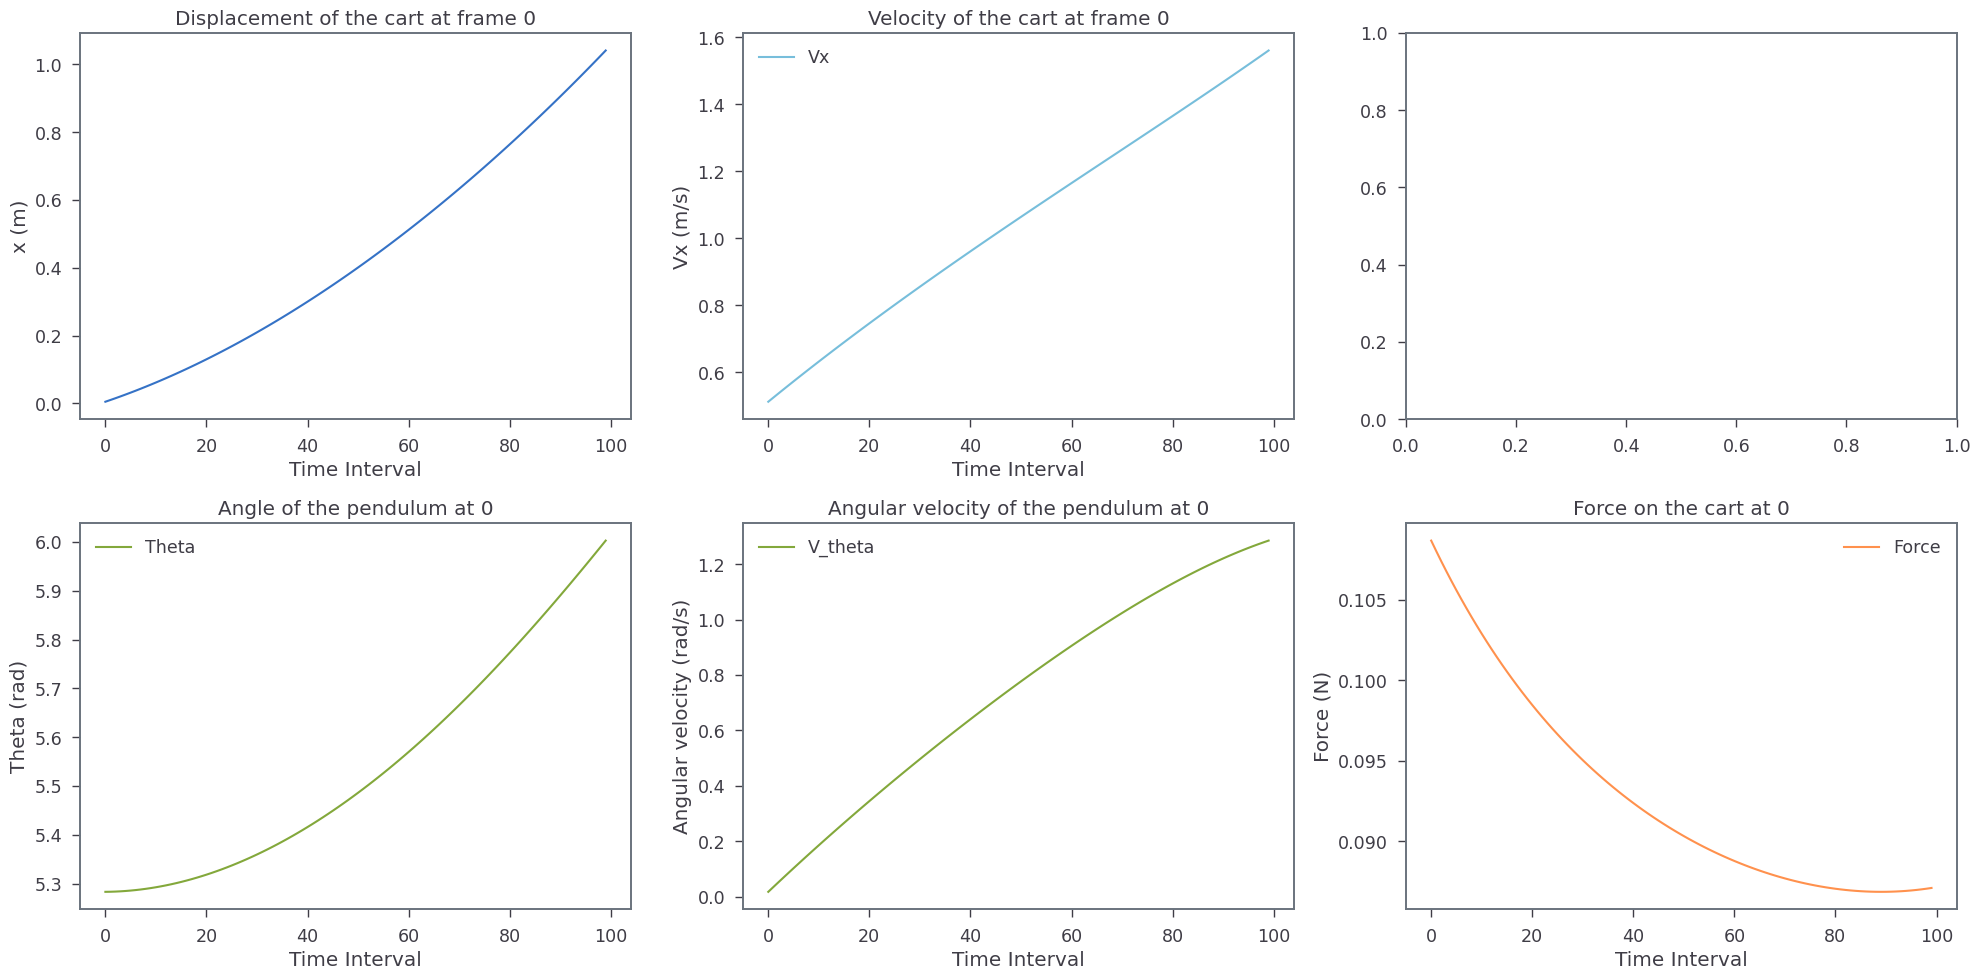

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5123744 Angular Velocity: 0.017354505 Force: 0.10866774
Angle: 302.71417526026187 5.283359 Displacement: 0.010123744 Velocity: 0.52467424 Angular Velocity: 0.034605026 Force: 0.1080151
Angle: 302.7340101296116 5.283705 Displacement: 0.015370486 Velocity: 0.53690135 Angular Velocity: 0.05175349 Force: 0.107380606
Angle: 302.76365315060946 5.2842226 Displacement: 0.0207395 Velocity: 0.54905754 Angular Velocity: 0.06880176 Force: 0.10676361
Angle: 302.80307700249875 5.2849107 Displacement: 0.026230074 Velocity: 0.5611446 Angular Velocity: 0.08575161 Force: 0.106163494
Angle: 302.8521997230095 5.285768 Displacement: 0.03184152 Velocity: 0.57316417 Angular Velocity: 0.102604754 Force: 0.10557974
Angle: 302.910993991385 5.286794 Displacement: 0.037573162 Velocity: 0.5851179 Angular Velocity: 0.119362846 Force: 0.10501182
Angle: 302.97937784535515 5.2879877 Displacement: 0.04342434 Velocity: 0.59700733 Angular Velocity: 0.1360

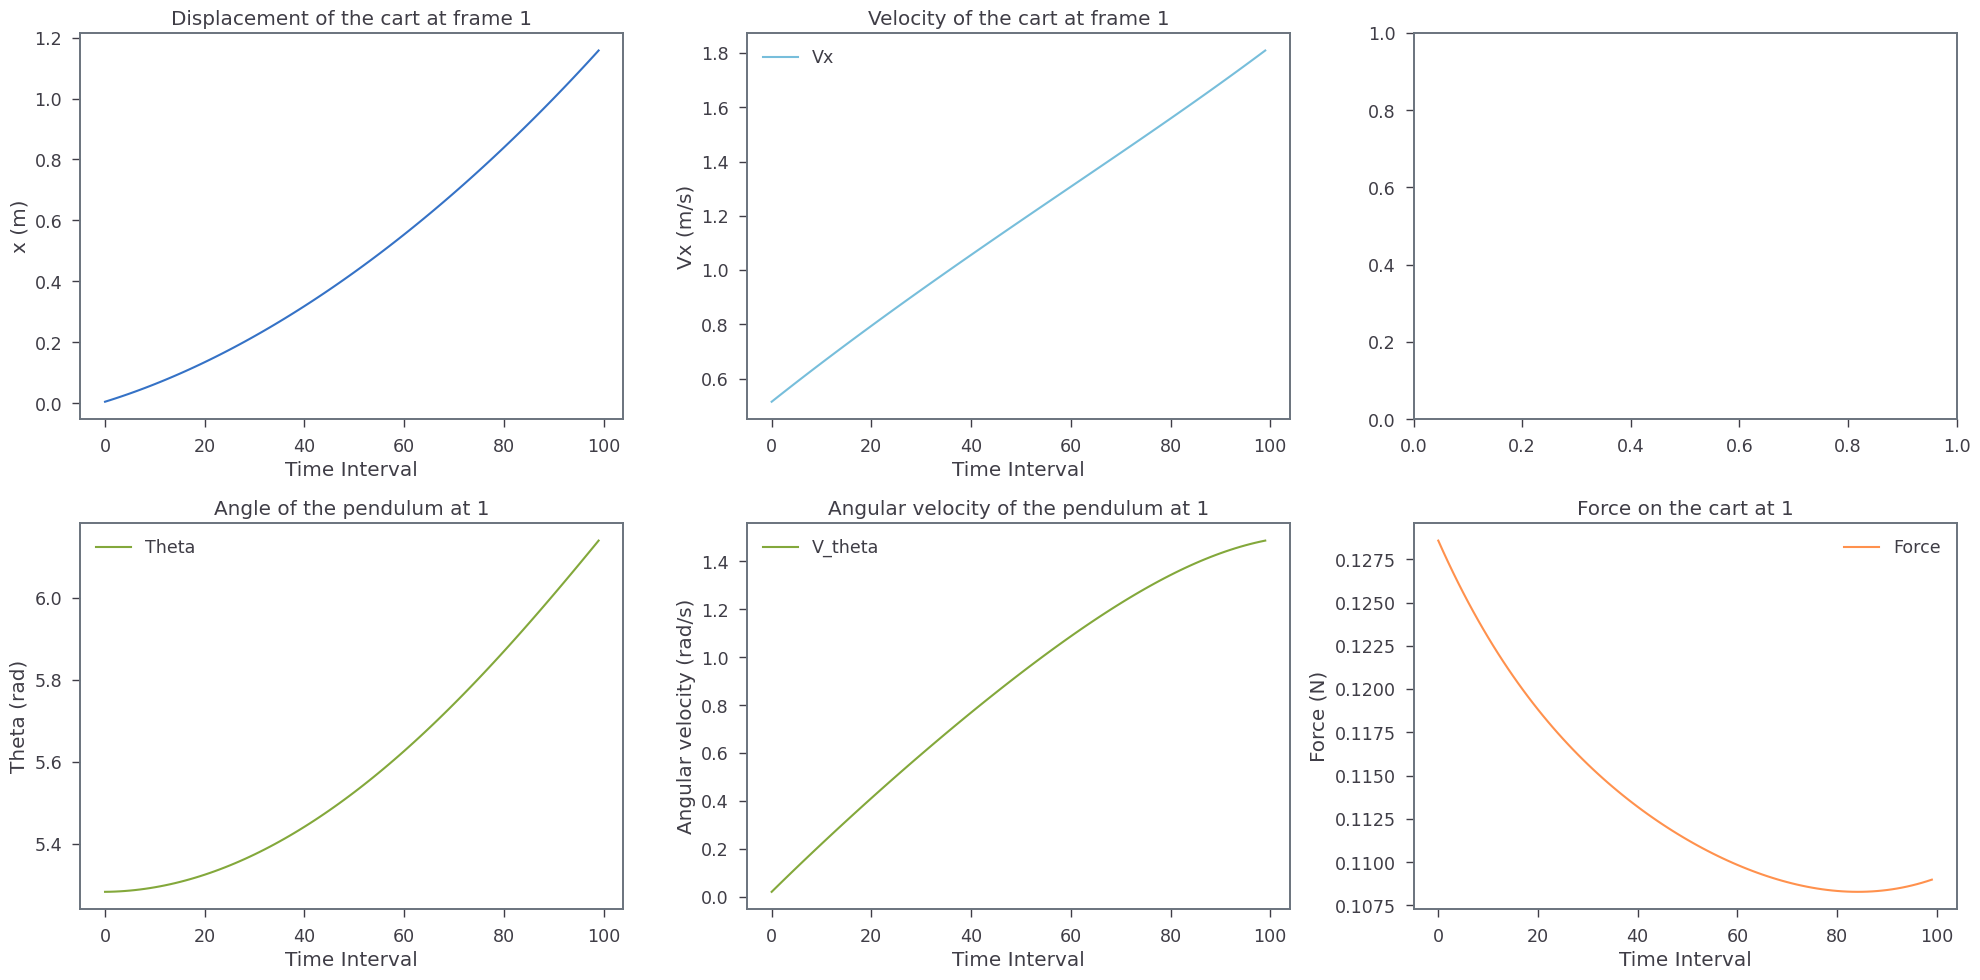

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5146419 Angular Velocity: 0.020534523 Force: 0.12857987
Angle: 302.7160057509594 5.283391 Displacement: 0.010146419 Velocity: 0.5292105 Angular Velocity: 0.040967148 Force: 0.12793972
Angle: 302.7394742809476 5.2838006 Displacement: 0.015438523 Velocity: 0.54370785 Angular Velocity: 0.061299674 Force: 0.12731928
Angle: 302.7745814532815 5.2844133 Displacement: 0.020875601 Velocity: 0.5581358 Angular Velocity: 0.081533805 Force: 0.12671782
Angle: 302.82129994720435 5.2852287 Displacement: 0.02645696 Velocity: 0.5724962 Angular Velocity: 0.10167117 Force: 0.12613463
Angle: 302.87954780044623 5.2862453 Displacement: 0.032181922 Velocity: 0.58679074 Angular Velocity: 0.12171329 Force: 0.12556909
Angle: 302.9492976922504 5.2874627 Displacement: 0.03804983 Velocity: 0.6010212 Angular Velocity: 0.14166161 Force: 0.1250205
Angle: 303.03046766034686 5.2888794 Displacement: 0.04406004 Velocity: 0.6151891 Angular Velocity: 0.16151

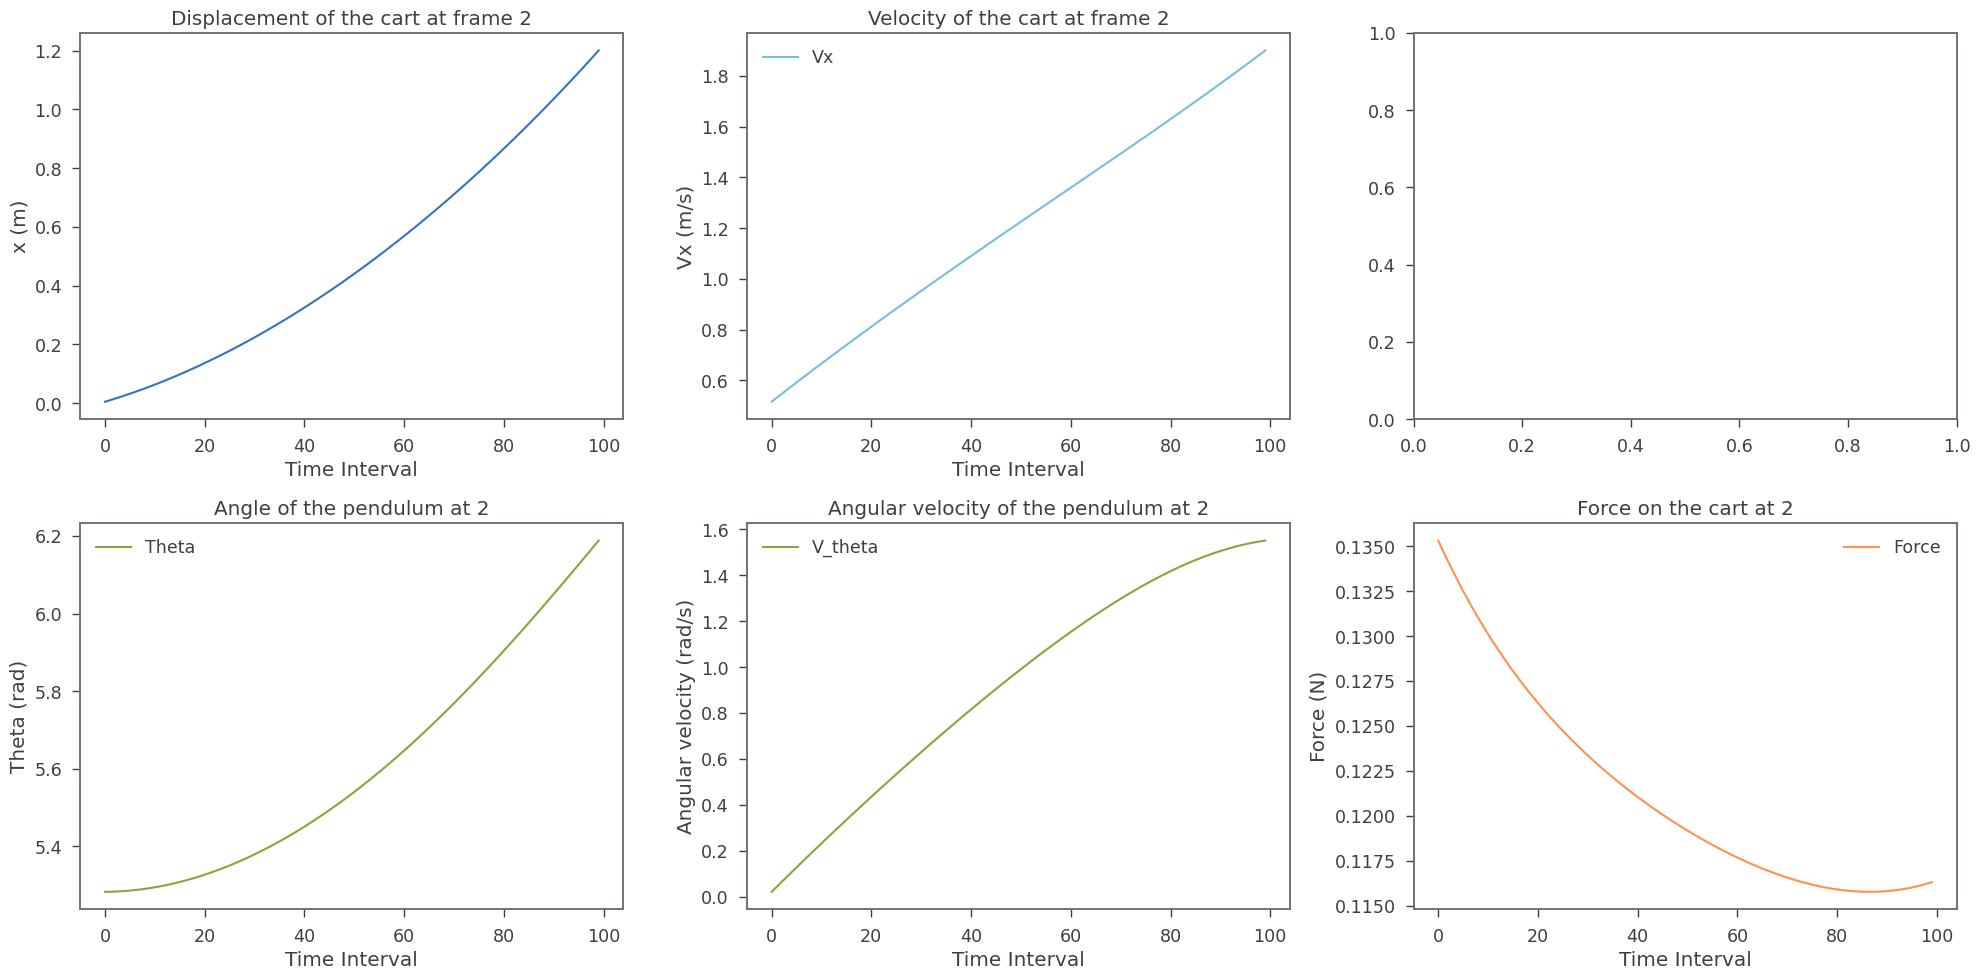

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.51540935 Angular Velocity: 0.021610891 Force: 0.13531971
Angle: 302.7166068076064 5.2834015 Displacement: 0.010154093 Velocity: 0.5307499 Angular Velocity: 0.04312627 Force: 0.1347193
Angle: 302.7413320924019 5.283833 Displacement: 0.015461592 Velocity: 0.54602367 Angular Velocity: 0.06454776 Force: 0.13413846
Angle: 302.77829707619 5.284478 Displacement: 0.020921828 Velocity: 0.5612324 Angular Velocity: 0.0858769 Force: 0.13357642
Angle: 302.82750175897075 5.285337 Displacement: 0.026534151 Velocity: 0.5763779 Angular Velocity: 0.10711512 Force: 0.13303247
Angle: 302.8888914992308 5.2864084 Displacement: 0.03229793 Velocity: 0.5914619 Angular Velocity: 0.12826376 Force: 0.13250583
Angle: 302.9623843347001 5.287691 Displacement: 0.03821255 Velocity: 0.60648596 Angular Velocity: 0.14932407 Force: 0.13199592
Angle: 303.0479256238654 5.289184 Displacement: 0.044277407 Velocity: 0.6214517 Angular Velocity: 0.1702972 Force: 

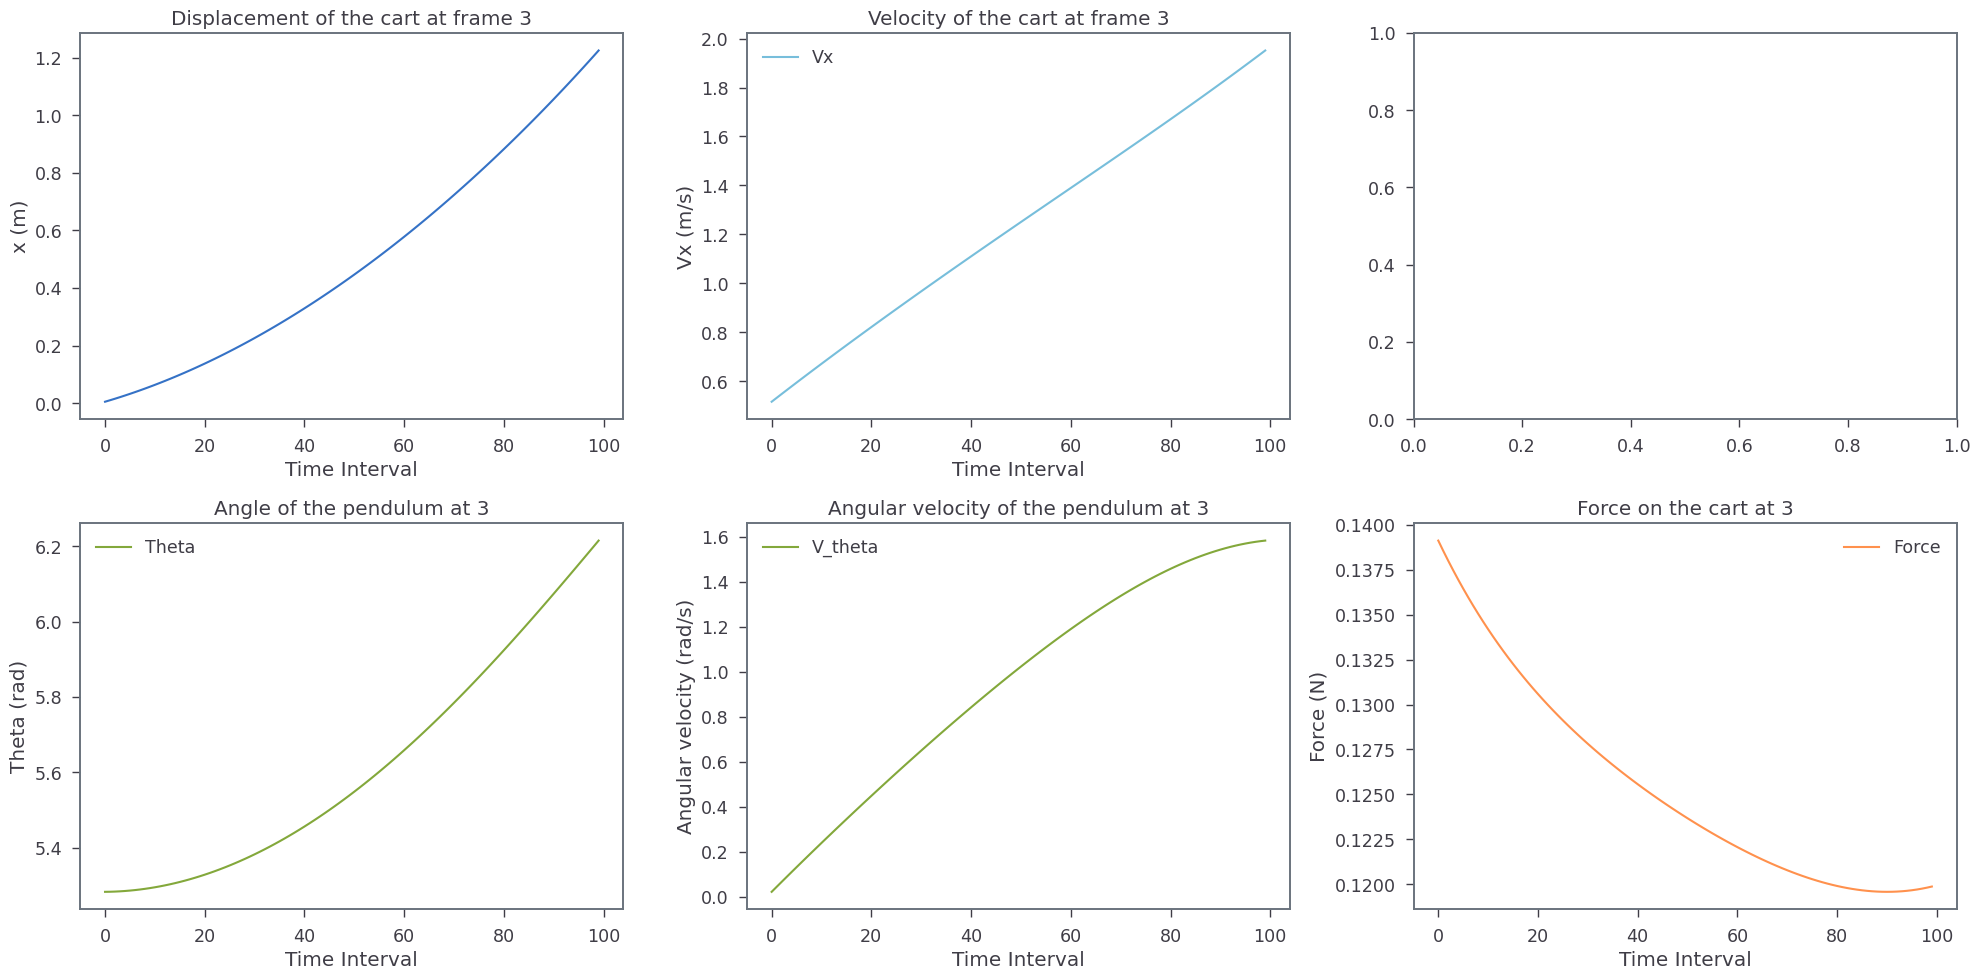

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5158416 Angular Velocity: 0.022217063 Force: 0.13911533
Angle: 302.71696197744325 5.2834077 Displacement: 0.010158416 Velocity: 0.5316177 Angular Velocity: 0.0443433 Force: 0.13854414
Angle: 302.7423702811557 5.283851 Displacement: 0.015474593 Velocity: 0.54733026 Angular Velocity: 0.06638023 Force: 0.13799241
Angle: 302.78040077445434 5.284515 Displacement: 0.020947896 Velocity: 0.562981 Angular Velocity: 0.08832927 Force: 0.13745925
Angle: 302.8309988158258 5.285398 Displacement: 0.026577706 Velocity: 0.57857174 Angular Velocity: 0.11019172 Force: 0.13694392
Angle: 302.8941370845134 5.2865 Displacement: 0.032363422 Velocity: 0.59410405 Angular Velocity: 0.1319688 Force: 0.13644566
Angle: 302.9697609390038 5.28782 Displacement: 0.038304463 Velocity: 0.60957956 Angular Velocity: 0.15366158 Force: 0.13596368
Angle: 303.05778841702687 5.289356 Displacement: 0.04440026 Velocity: 0.62499976 Angular Velocity: 0.1752711 Force

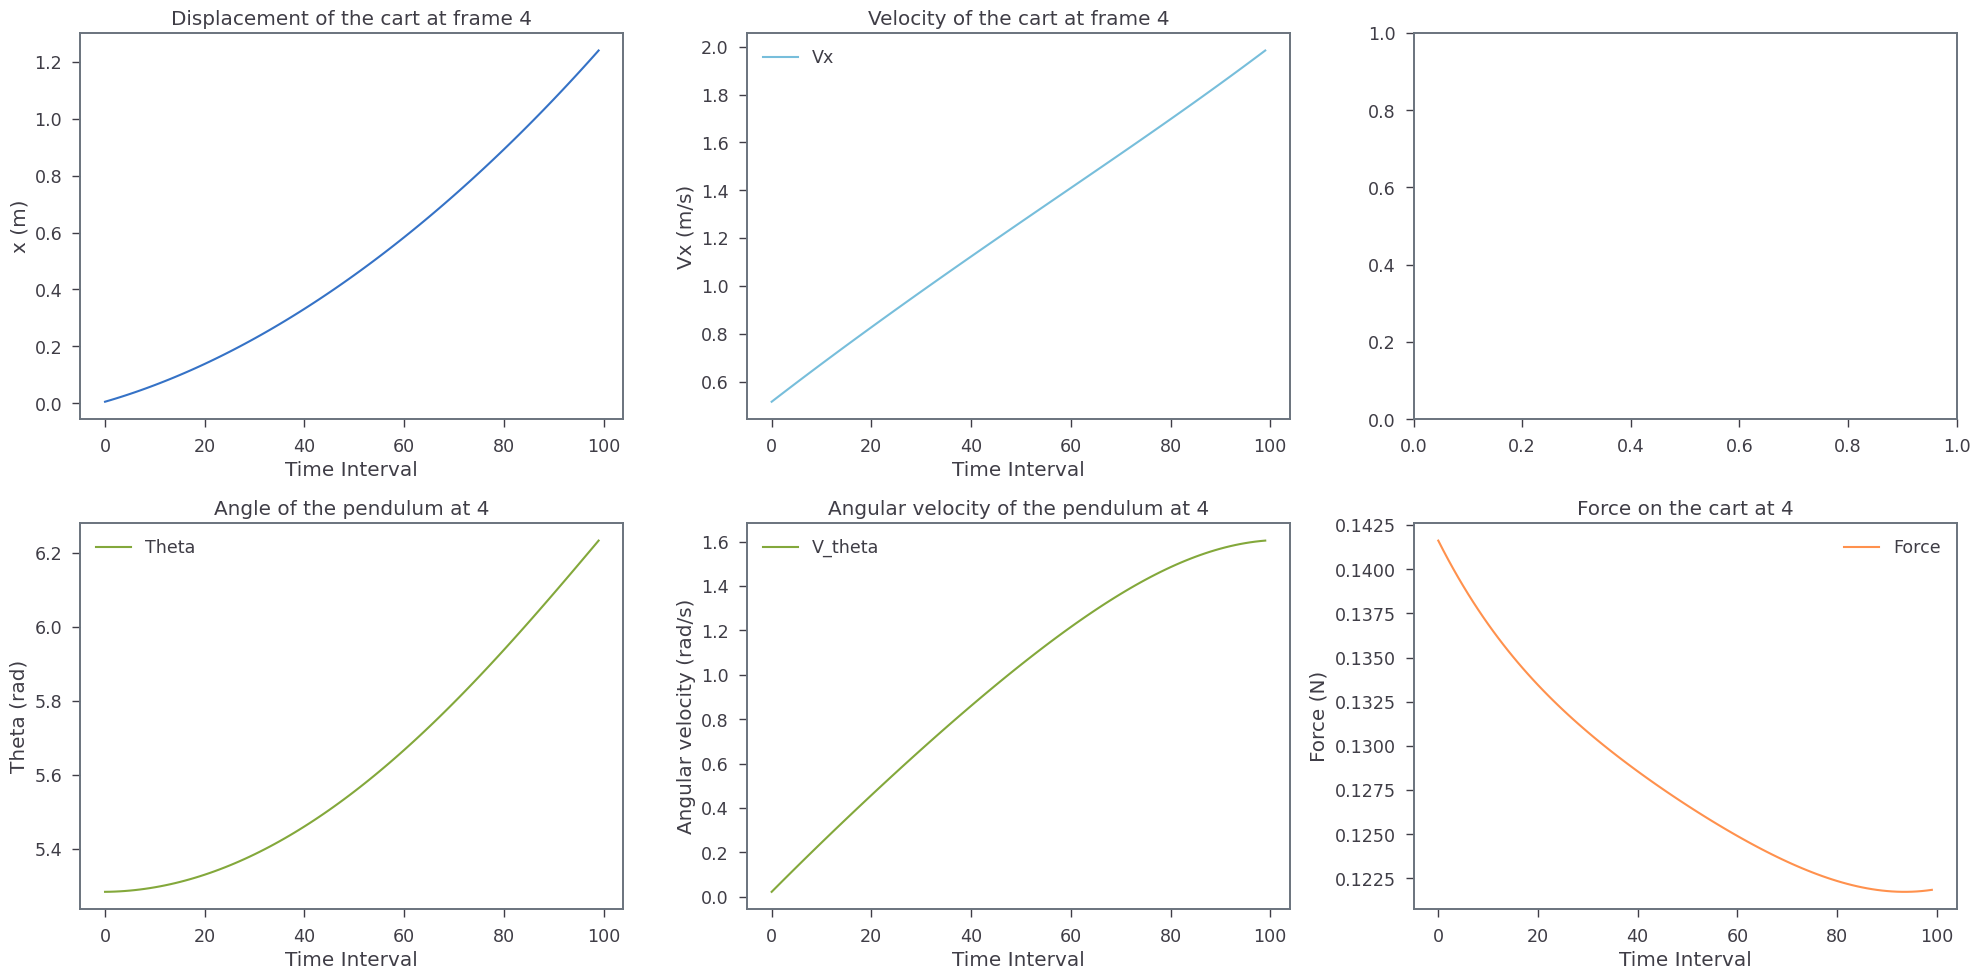

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.51612705 Angular Velocity: 0.022617407 Force: 0.14162216
Angle: 302.7171805434967 5.2834115 Displacement: 0.01016127 Velocity: 0.532191 Angular Velocity: 0.045147303 Force: 0.14107163
Angle: 302.7430533000727 5.283863 Displacement: 0.01548318 Velocity: 0.54819363 Angular Velocity: 0.06759113 Force: 0.14054042
Angle: 302.781794133045 5.284539 Displacement: 0.020965116 Velocity: 0.5641368 Angular Velocity: 0.089950204 Force: 0.14002761
Angle: 302.8333210801436 5.2854385 Displacement: 0.026606483 Velocity: 0.58002216 Angular Velocity: 0.112225756 Force: 0.13953246
Angle: 302.8976341413684 5.286561 Displacement: 0.032406706 Velocity: 0.59585136 Angular Velocity: 0.13441889 Force: 0.13905412
Angle: 302.9746240336928 5.2879047 Displacement: 0.03836522 Velocity: 0.6116259 Angular Velocity: 0.1565306 Force: 0.13859187
Angle: 303.0643180778734 5.28947 Displacement: 0.04448148 Velocity: 0.62734723 Angular Velocity: 0.1785618 Forc

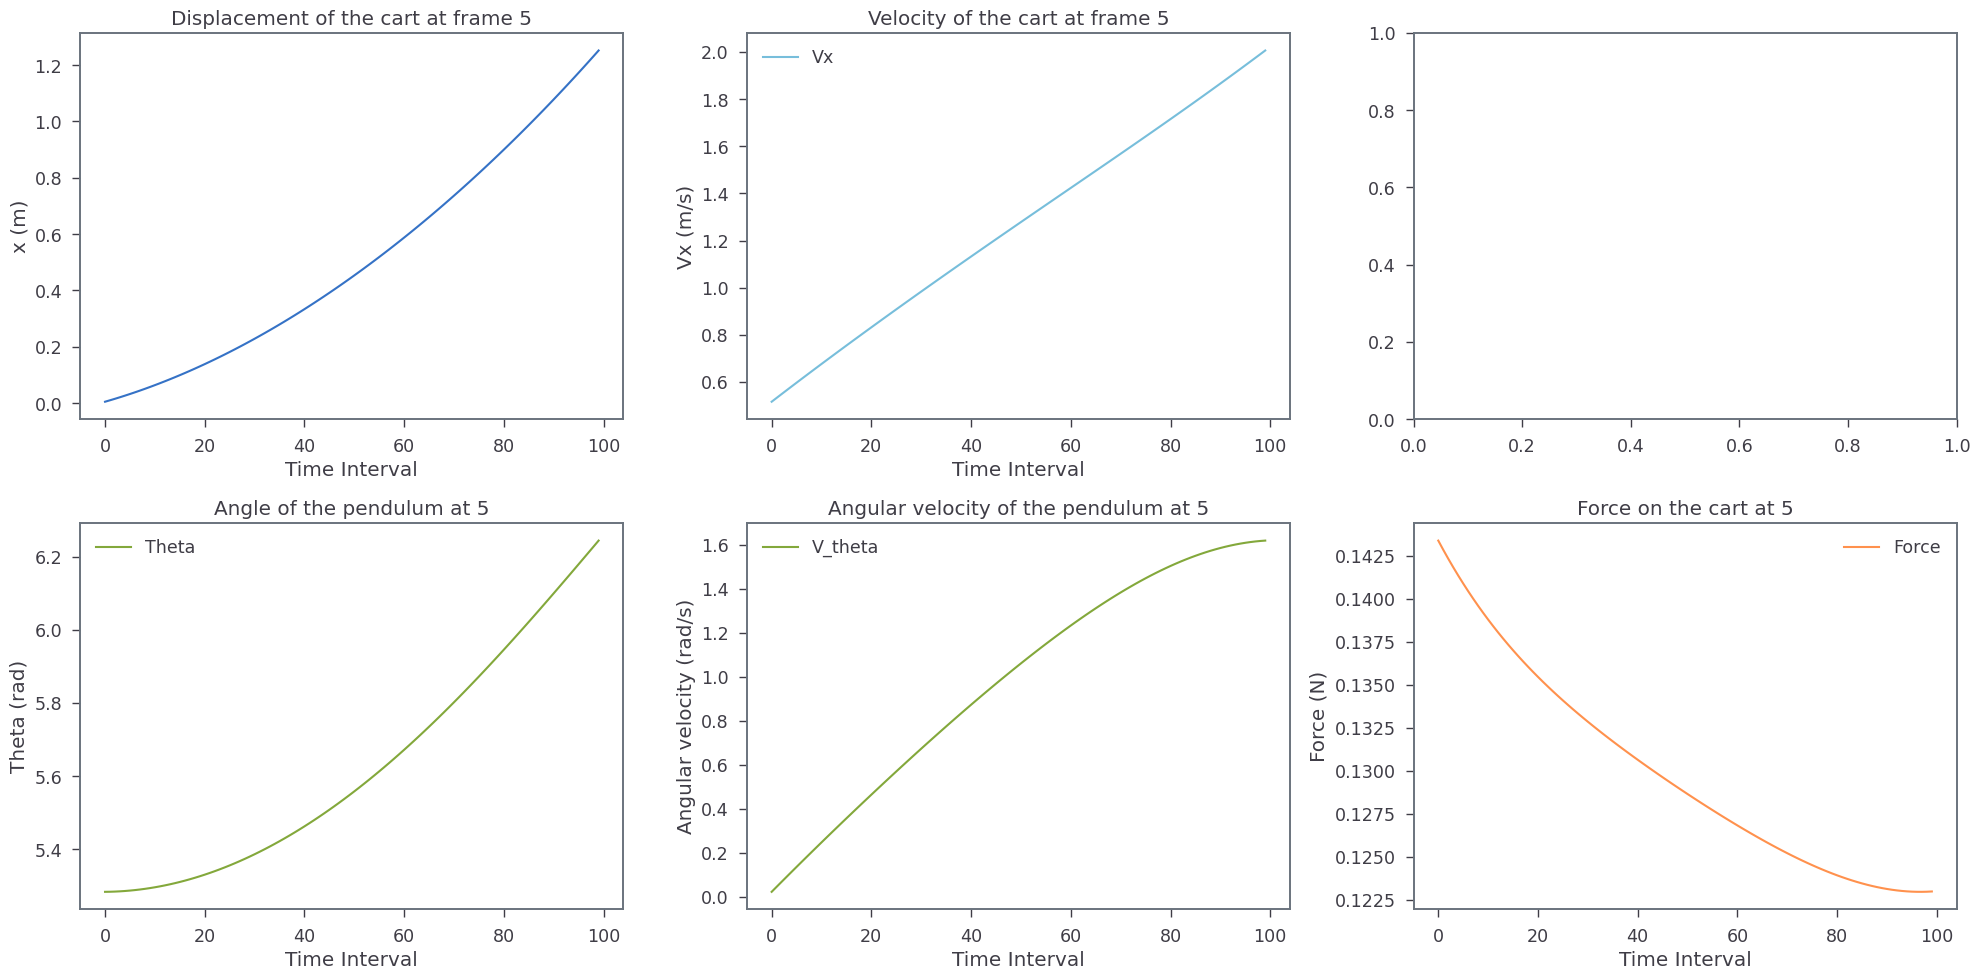

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.51632863 Angular Velocity: 0.022900108 Force: 0.14339234
Angle: 302.71734446803674 5.2834144 Displacement: 0.010163287 Velocity: 0.5325958 Angular Velocity: 0.045715097 Force: 0.14285672
Angle: 302.7435450736929 5.2838717 Displacement: 0.015489245 Velocity: 0.5488034 Angular Velocity: 0.068446346 Force: 0.1423403
Angle: 302.7827503595288 5.284556 Displacement: 0.02097728 Velocity: 0.56495315 Angular Velocity: 0.091095135 Force: 0.14184225
Angle: 302.8349603255444 5.285467 Displacement: 0.02662681 Velocity: 0.5810467 Angular Velocity: 0.1136626 Force: 0.14136167
Angle: 302.90006568871297 5.2866035 Displacement: 0.032437276 Velocity: 0.5970857 Angular Velocity: 0.1361498 Force: 0.14089772
Angle: 302.9780937697912 5.2879653 Displacement: 0.038408134 Velocity: 0.6130716 Angular Velocity: 0.15855762 Force: 0.1404497
Angle: 303.06893528575233 5.289551 Displacement: 0.04453885 Velocity: 0.62900585 Angular Velocity: 0.18088692 

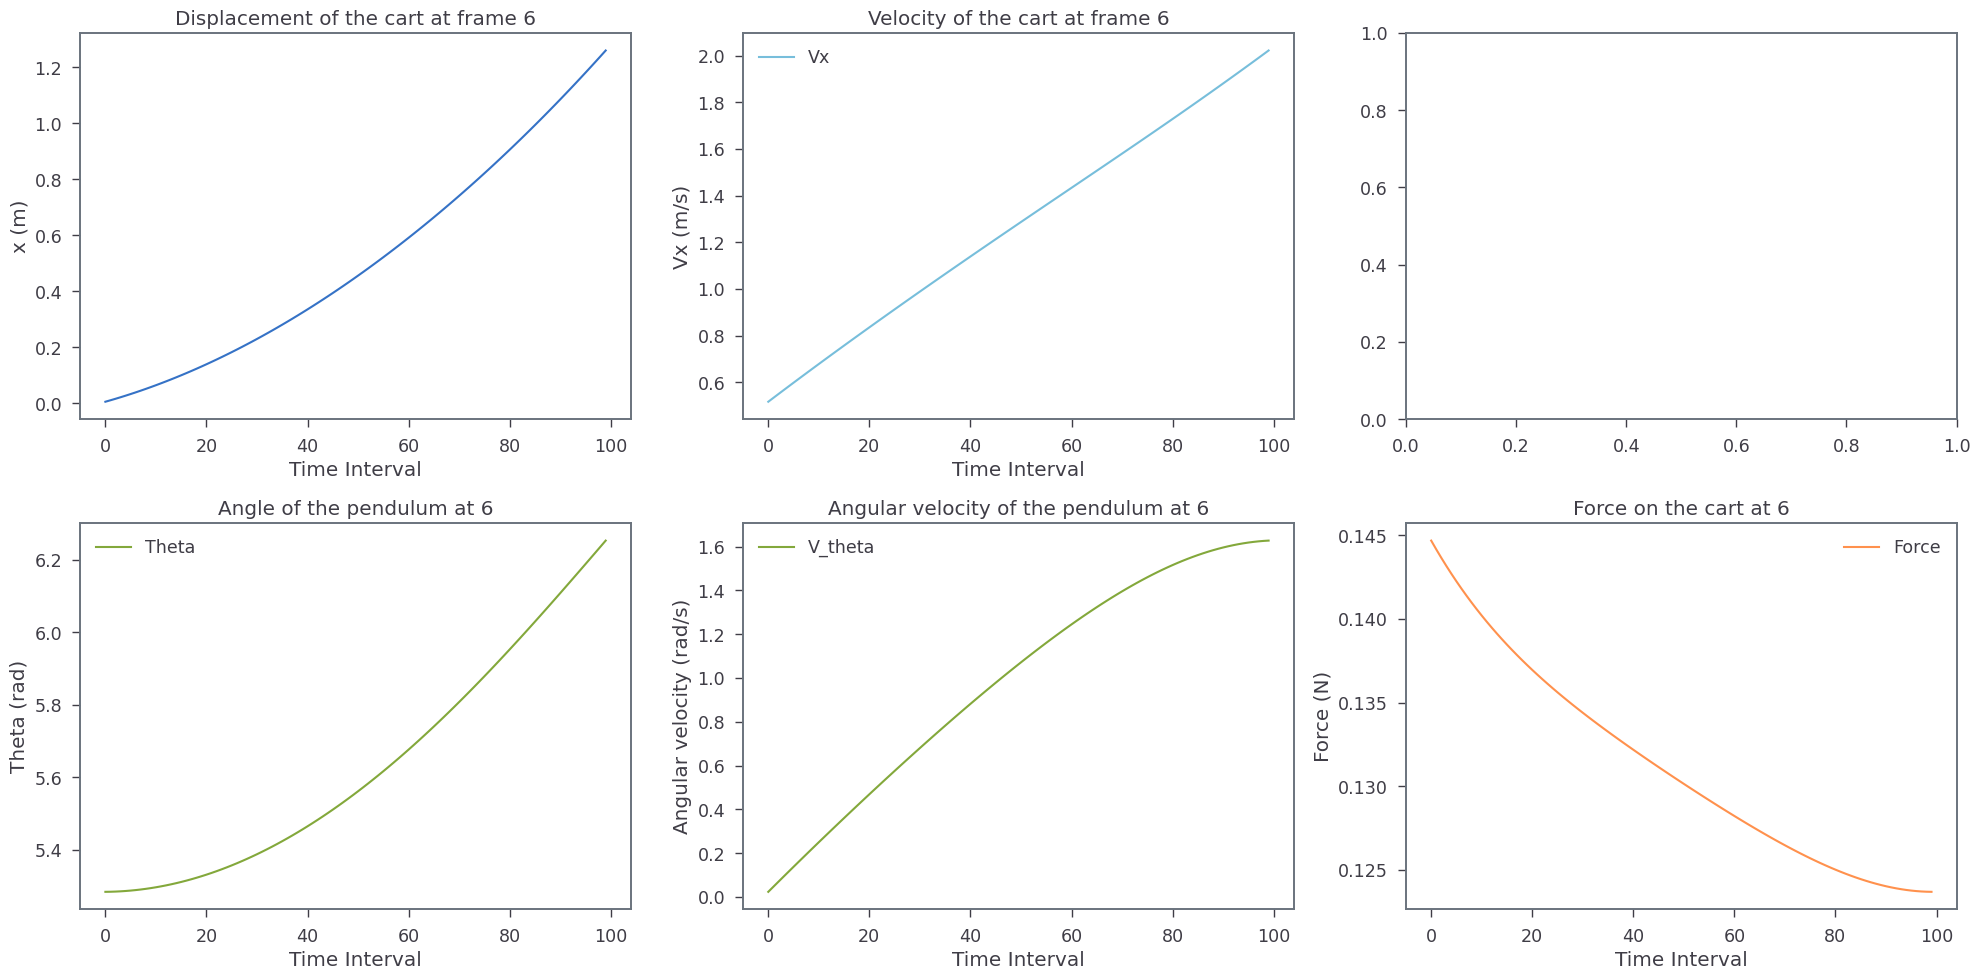

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.51647514 Angular Velocity: 0.023105625 Force: 0.14467919
Angle: 302.71748107182015 5.2834167 Displacement: 0.010164751 Velocity: 0.5328902 Angular Velocity: 0.046128027 Force: 0.14415541
Angle: 302.74390024352977 5.283878 Displacement: 0.015493653 Velocity: 0.54924697 Angular Velocity: 0.069068536 Force: 0.14365073
Angle: 302.78346069920246 5.2845683 Displacement: 0.020986123 Velocity: 0.5655472 Angular Velocity: 0.091928385 Force: 0.14316429
Angle: 302.83613511808164 5.2854877 Displacement: 0.026641596 Velocity: 0.5817926 Angular Velocity: 0.11470867 Force: 0.1426952
Angle: 302.9018688586538 5.286635 Displacement: 0.032459524 Velocity: 0.5979846 Angular Velocity: 0.13741037 Force: 0.14224264
Angle: 302.9806072794057 5.288009 Displacement: 0.03843937 Velocity: 0.6141248 Angular Velocity: 0.16003436 Force: 0.1418058
Angle: 303.072295738824 5.2896094 Displacement: 0.04458062 Velocity: 0.6302145 Angular Velocity: 0.1825813

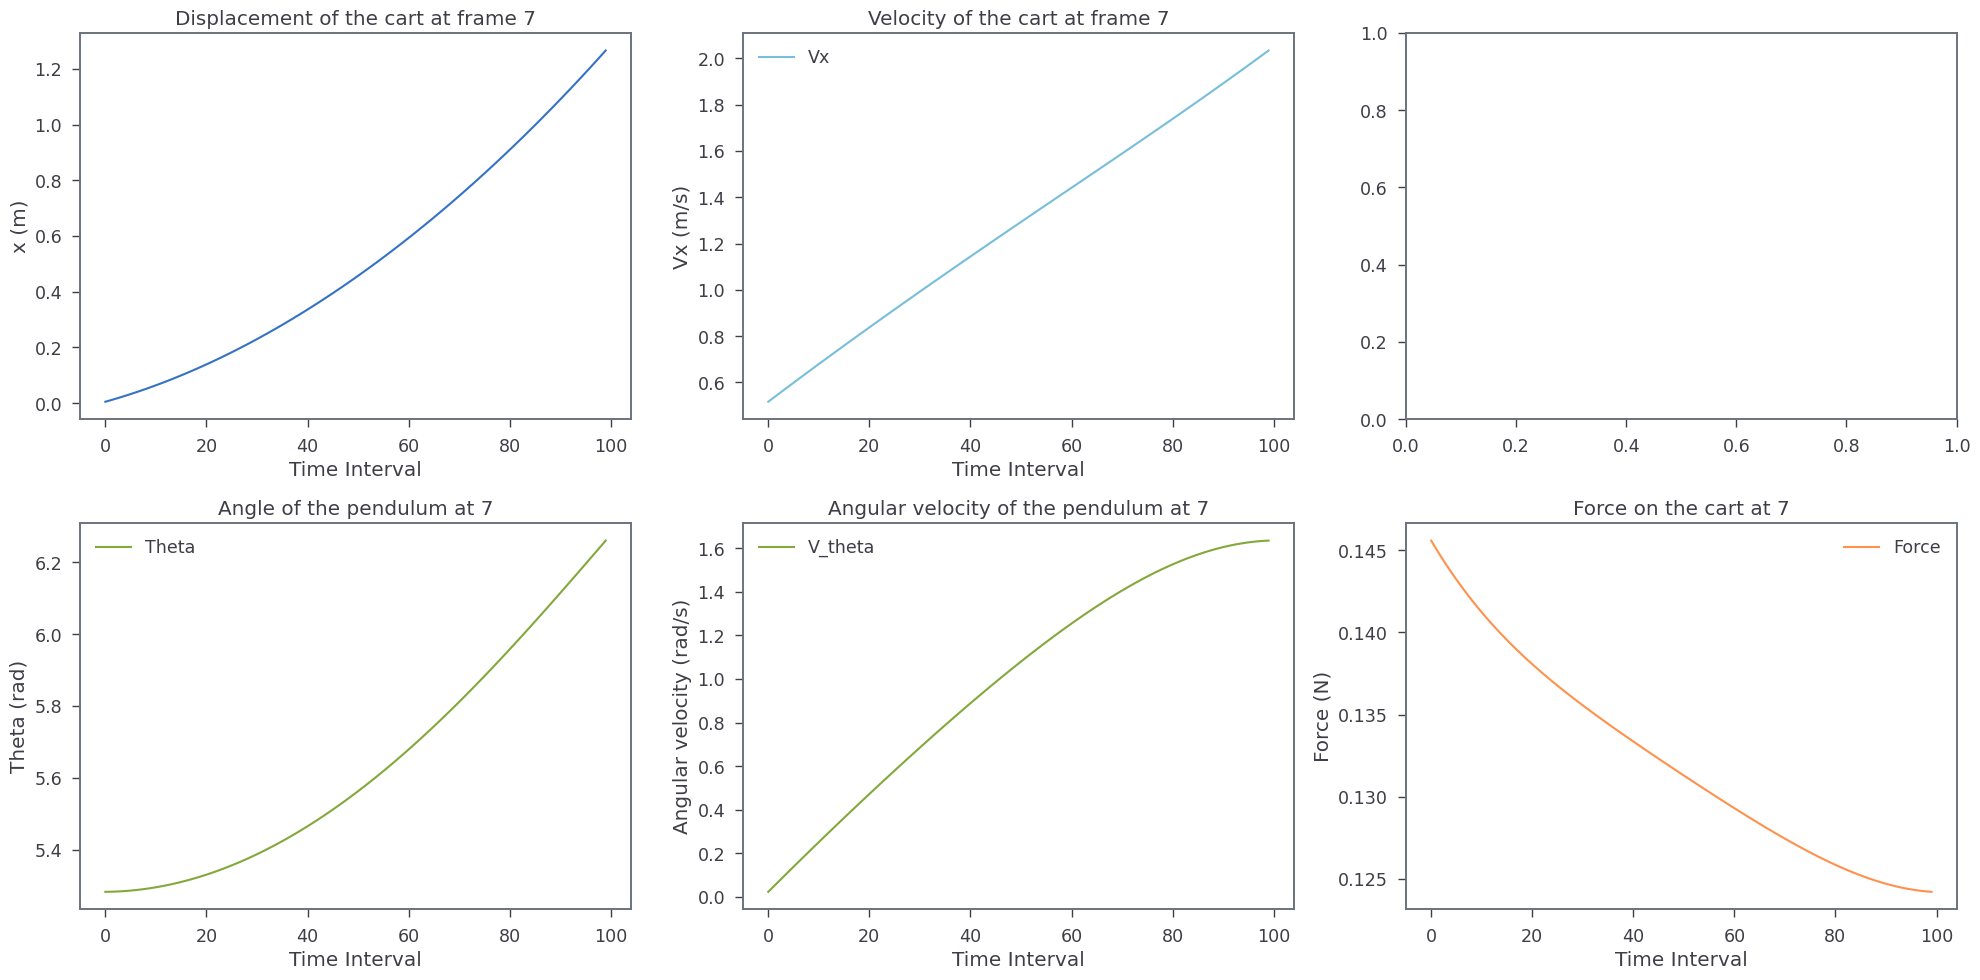

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5165785 Angular Velocity: 0.023250556 Force: 0.1455867
Angle: 302.71756303409023 5.283418 Displacement: 0.0101657845 Velocity: 0.53309834 Angular Velocity: 0.046419933 Force: 0.14507568
Angle: 302.7441461303399 5.283882 Displacement: 0.015496768 Velocity: 0.5495613 Angular Velocity: 0.06950942 Force: 0.1445836
Angle: 302.7839797935794 5.2845774 Displacement: 0.020992381 Velocity: 0.56596917 Angular Velocity: 0.09252018 Force: 0.14410958
Angle: 302.8369820615387 5.2855024 Displacement: 0.026652073 Velocity: 0.5823235 Angular Velocity: 0.11545326 Force: 0.14365268
Angle: 302.9031256134611 5.286657 Displacement: 0.032475308 Velocity: 0.59862584 Angular Velocity: 0.13830958 Force: 0.14321212
Angle: 302.98238312858996 5.28804 Displacement: 0.038461566 Velocity: 0.61487764 Angular Velocity: 0.16108996 Force: 0.14278704
Angle: 303.07467264465515 5.289651 Displacement: 0.044610344 Velocity: 0.63108027 Angular Velocity: 0.183795

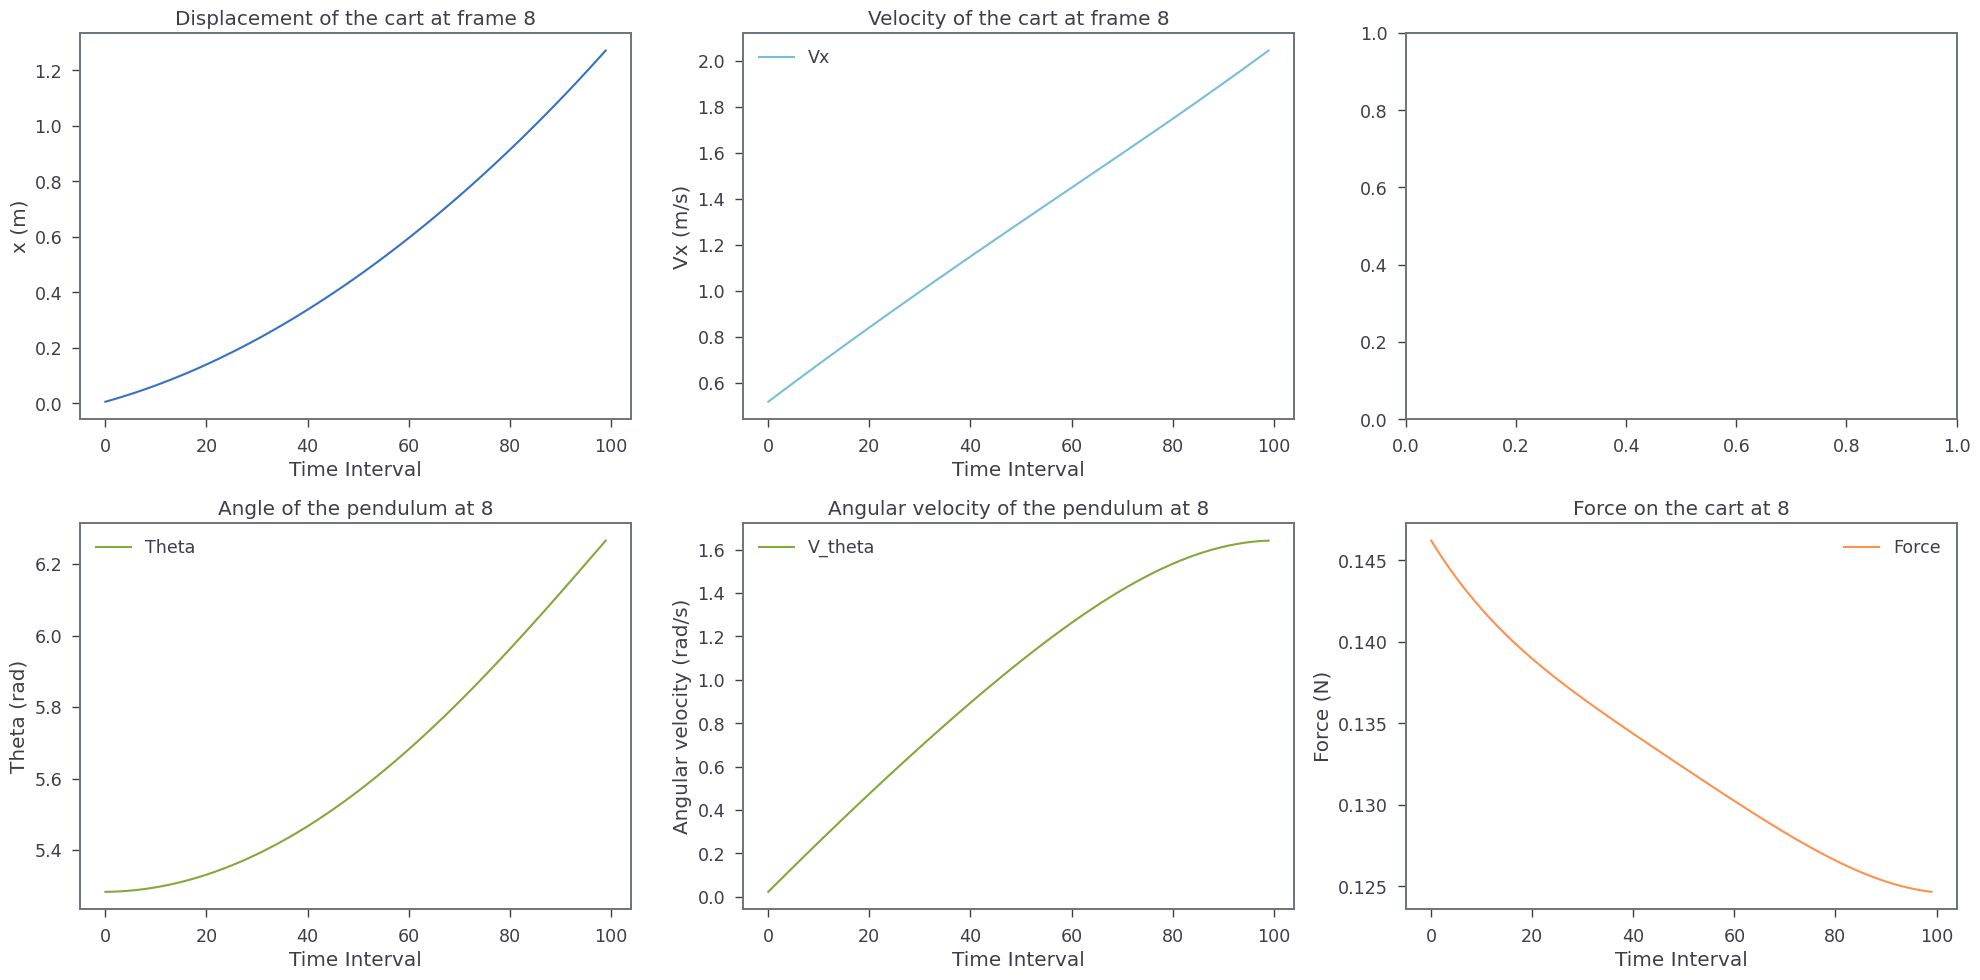

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5166484 Angular Velocity: 0.02334855 Force: 0.14620031
Angle: 302.71761767560355 5.283419 Displacement: 0.010166484 Velocity: 0.5332401 Angular Velocity: 0.046618626 Force: 0.14570622
Angle: 302.74431005488 5.283885 Displacement: 0.015498884 Velocity: 0.54977673 Angular Velocity: 0.069811456 Force: 0.14523076
Angle: 302.7843076426596 5.284583 Displacement: 0.02099665 Velocity: 0.5662601 Angular Velocity: 0.092928134 Force: 0.144773
Angle: 302.837555797429 5.2855124 Displacement: 0.026659252 Velocity: 0.5826918 Angular Velocity: 0.11596964 Force: 0.1443321
Angle: 302.9039998776749 5.286672 Displacement: 0.03248617 Velocity: 0.59907323 Angular Velocity: 0.13893682 Force: 0.14390711
Angle: 302.98361256264053 5.2880616 Displacement: 0.038476903 Velocity: 0.61540586 Angular Velocity: 0.16183043 Force: 0.14349735
Angle: 303.07633921081265 5.28968 Displacement: 0.04463096 Velocity: 0.631691 Angular Velocity: 0.18465105 Force: 

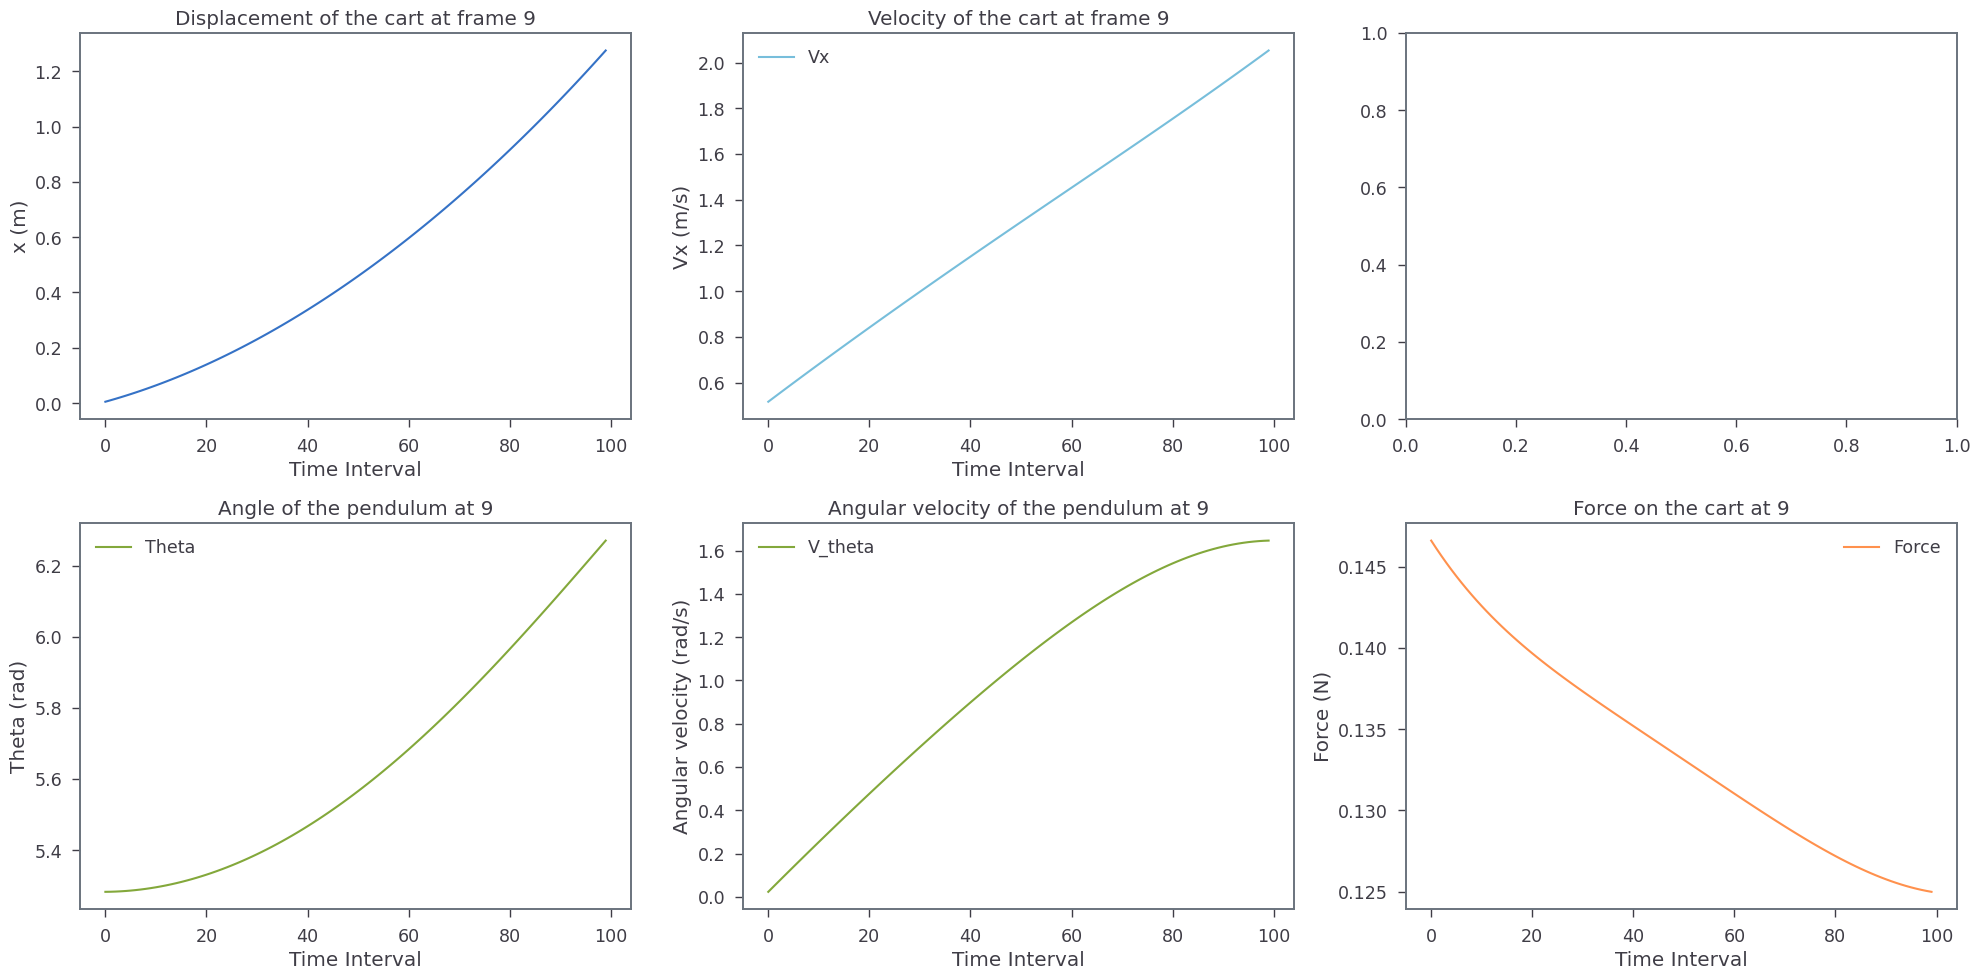

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5166948 Angular Velocity: 0.023413653 Force: 0.14660797
Angle: 302.71764499636026 5.2834196 Displacement: 0.010166948 Velocity: 0.53333503 Angular Velocity: 0.04675191 Force: 0.14613312
Angle: 302.7444193379067 5.283887 Displacement: 0.015500298 Velocity: 0.54992247 Angular Velocity: 0.07001592 Force: 0.14567655
Angle: 302.7845535294697 5.2845874 Displacement: 0.020999523 Velocity: 0.5664587 Angular Velocity: 0.09320672 Force: 0.14523725
Angle: 302.8379656087792 5.2855196 Displacement: 0.02666411 Velocity: 0.5829453 Angular Velocity: 0.11632519 Force: 0.14481439
Angle: 302.9046009343218 5.2866826 Displacement: 0.03249356 Velocity: 0.59938365 Angular Velocity: 0.13937213 Force: 0.14440708
Angle: 302.9844595060976 5.2880764 Displacement: 0.038487397 Velocity: 0.6157751 Angular Velocity: 0.16234815 Force: 0.14401451
Angle: 303.07745936183653 5.2896996 Displacement: 0.04464515 Velocity: 0.63212097 Angular Velocity: 0.185253

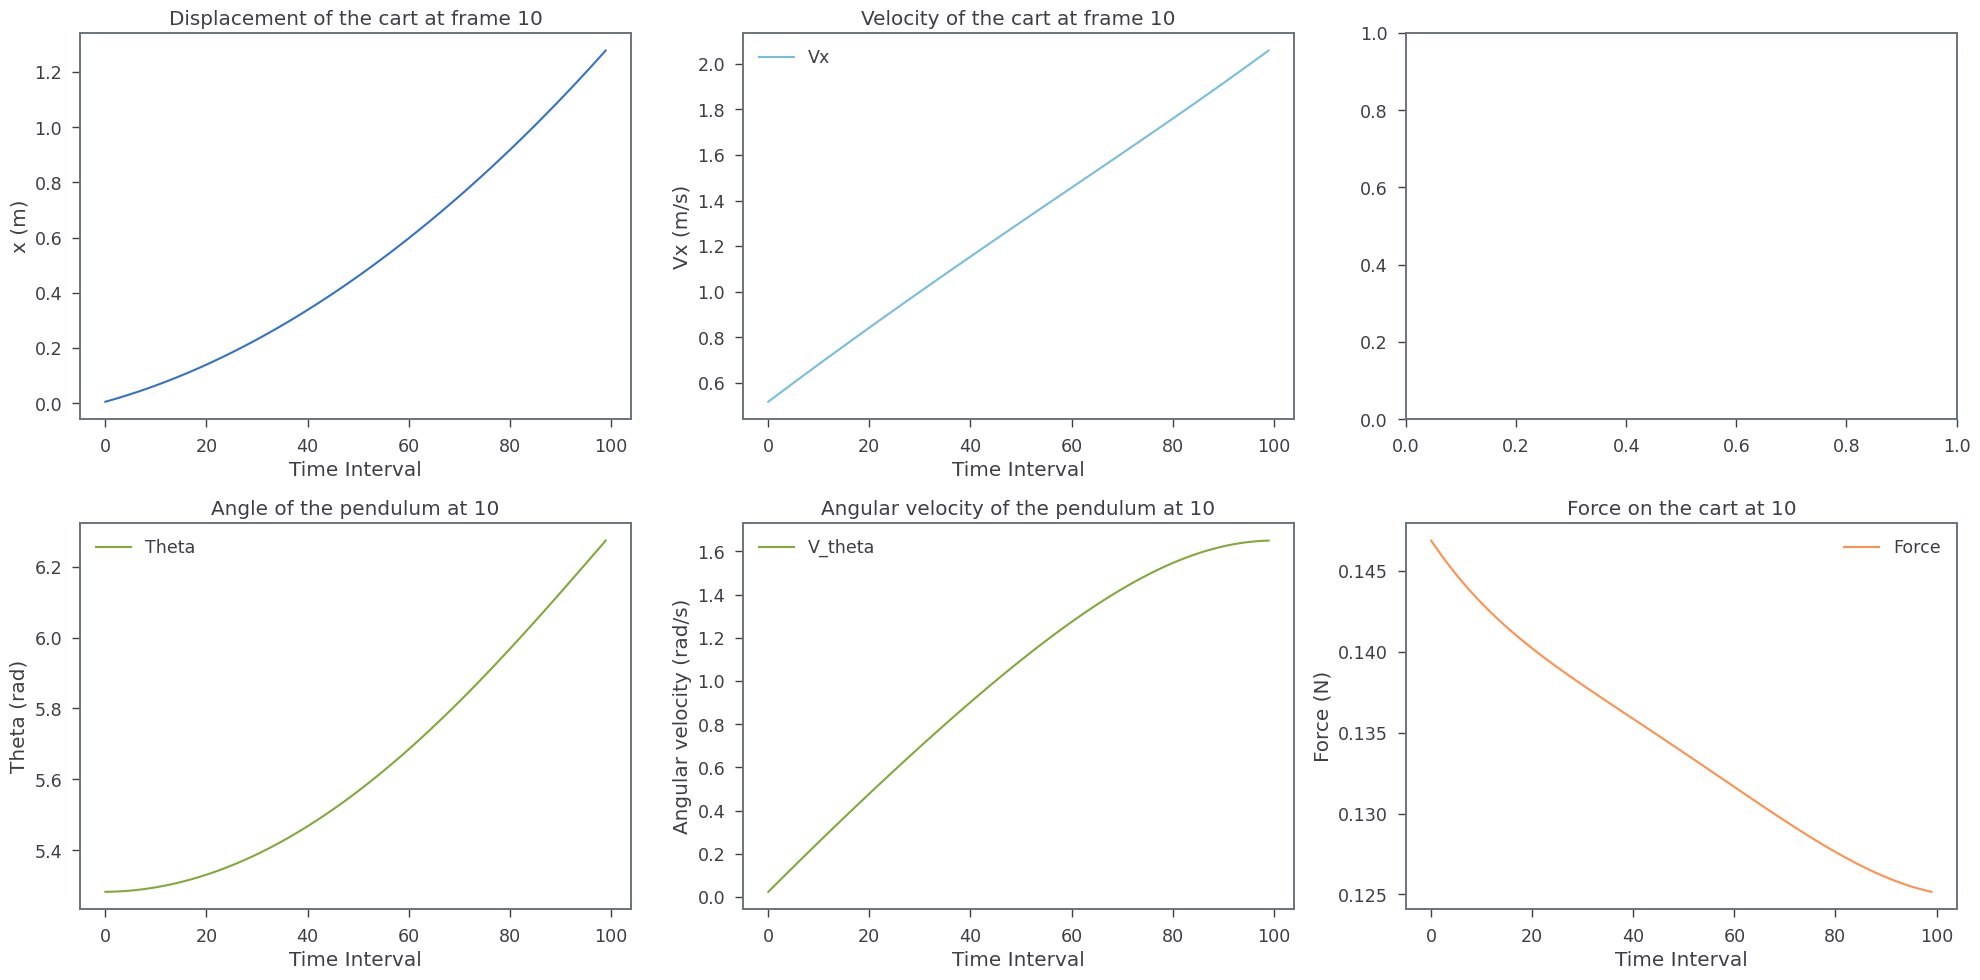

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5167259 Angular Velocity: 0.02345723 Force: 0.1468808
Angle: 302.7176723171169 5.28342 Displacement: 0.010167259 Velocity: 0.5333992 Angular Velocity: 0.046841845 Force: 0.14642338
Angle: 302.74450130017675 5.2838883 Displacement: 0.015501251 Velocity: 0.55002165 Angular Velocity: 0.07015493 Force: 0.14598382
Angle: 302.7846901332531 5.28459 Displacement: 0.021001467 Velocity: 0.5665948 Angular Velocity: 0.09339743 Force: 0.14556116
Angle: 302.8382114955893 5.285524 Displacement: 0.026667416 Velocity: 0.58312005 Angular Velocity: 0.11657019 Force: 0.14515454
Angle: 302.90501074567203 5.2866898 Displacement: 0.032498617 Velocity: 0.59959894 Angular Velocity: 0.1396739 Force: 0.14476311
Angle: 302.98503324198794 5.2880864 Displacement: 0.038494606 Velocity: 0.6160327 Angular Velocity: 0.16270915 Force: 0.14438601
Angle: 303.07825166378024 5.2897134 Displacement: 0.044654932 Velocity: 0.63242257 Angular Velocity: 0.1856764

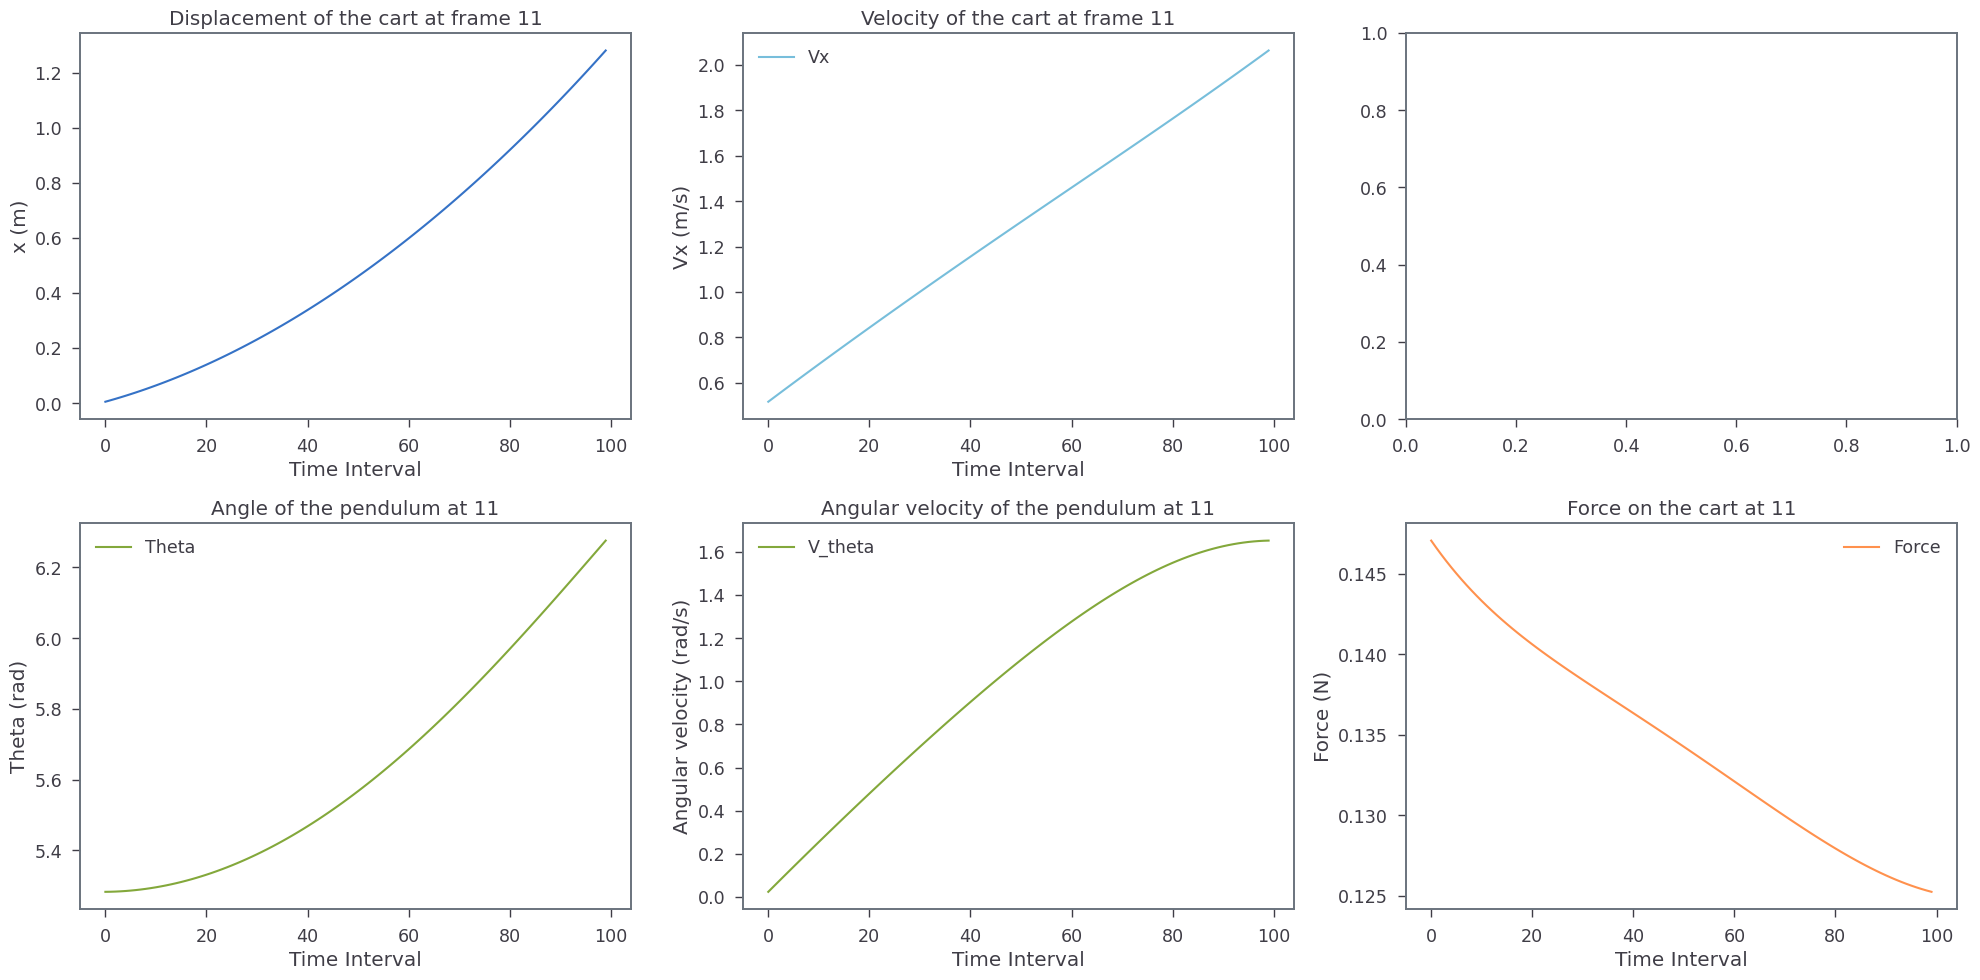

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5167474 Angular Velocity: 0.023487443 Force: 0.14707
Angle: 302.71769963787364 5.2834206 Displacement: 0.010167474 Velocity: 0.5334438 Angular Velocity: 0.046904482 Force: 0.14662641
Angle: 302.7445559416901 5.2838893 Displacement: 0.015501912 Velocity: 0.55009085 Angular Velocity: 0.070252135 Force: 0.14620031
Angle: 302.78479941627984 5.2845917 Displacement: 0.02100282 Velocity: 0.5666901 Angular Velocity: 0.09353132 Force: 0.14579089
Angle: 302.83840274088607 5.285527 Displacement: 0.02666972 Velocity: 0.583243 Angular Velocity: 0.1167428 Force: 0.14539719
Angle: 302.90528395323884 5.2866945 Displacement: 0.032502152 Velocity: 0.59975094 Angular Velocity: 0.13988723 Force: 0.14501835
Angle: 302.9854430533381 5.2880936 Displacement: 0.03849966 Velocity: 0.6162151 Angular Velocity: 0.16296512 Force: 0.14465353
Angle: 303.0788253996705 5.2897234 Displacement: 0.044661812 Velocity: 0.6326368 Angular Velocity: 0.18597688 

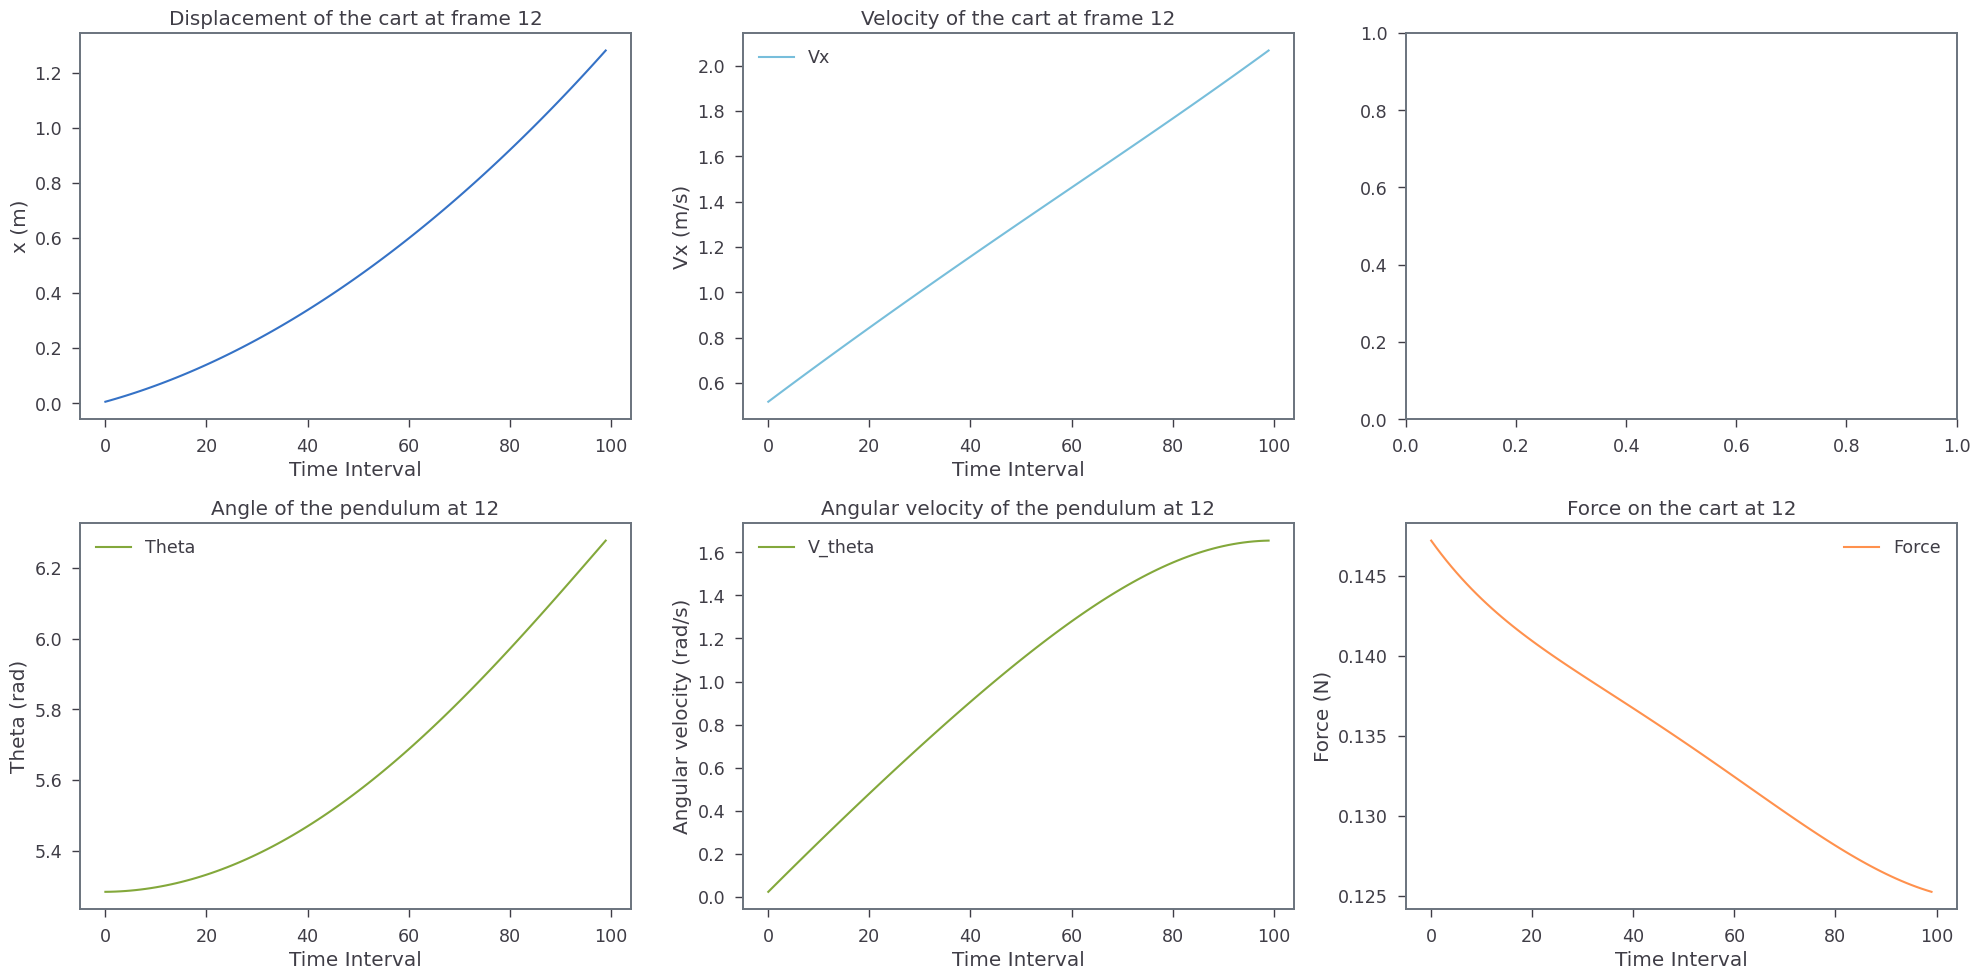

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5167626 Angular Velocity: 0.023508746 Force: 0.1472034
Angle: 302.71769963787364 5.2834206 Displacement: 0.010167626 Velocity: 0.53347546 Angular Velocity: 0.046948805 Force: 0.14677054
Angle: 302.74461058320344 5.2838902 Displacement: 0.01550238 Velocity: 0.55014014 Angular Velocity: 0.07032117 Force: 0.146355
Angle: 302.78488137854987 5.284593 Displacement: 0.02100378 Velocity: 0.56675816 Angular Velocity: 0.093626685 Force: 0.14595585
Angle: 302.83853934466947 5.2855296 Displacement: 0.026671361 Velocity: 0.583331 Angular Velocity: 0.1168661 Force: 0.14557219
Angle: 302.90550251929227 5.2866983 Displacement: 0.03250467 Velocity: 0.59985995 Angular Velocity: 0.14004 Force: 0.14520316
Angle: 302.9857435816616 5.288099 Displacement: 0.03850327 Velocity: 0.61634624 Angular Velocity: 0.16314887 Force: 0.1448479
Angle: 303.07920789026406 5.28973 Displacement: 0.044666734 Velocity: 0.6327911 Angular Velocity: 0.18619306 For

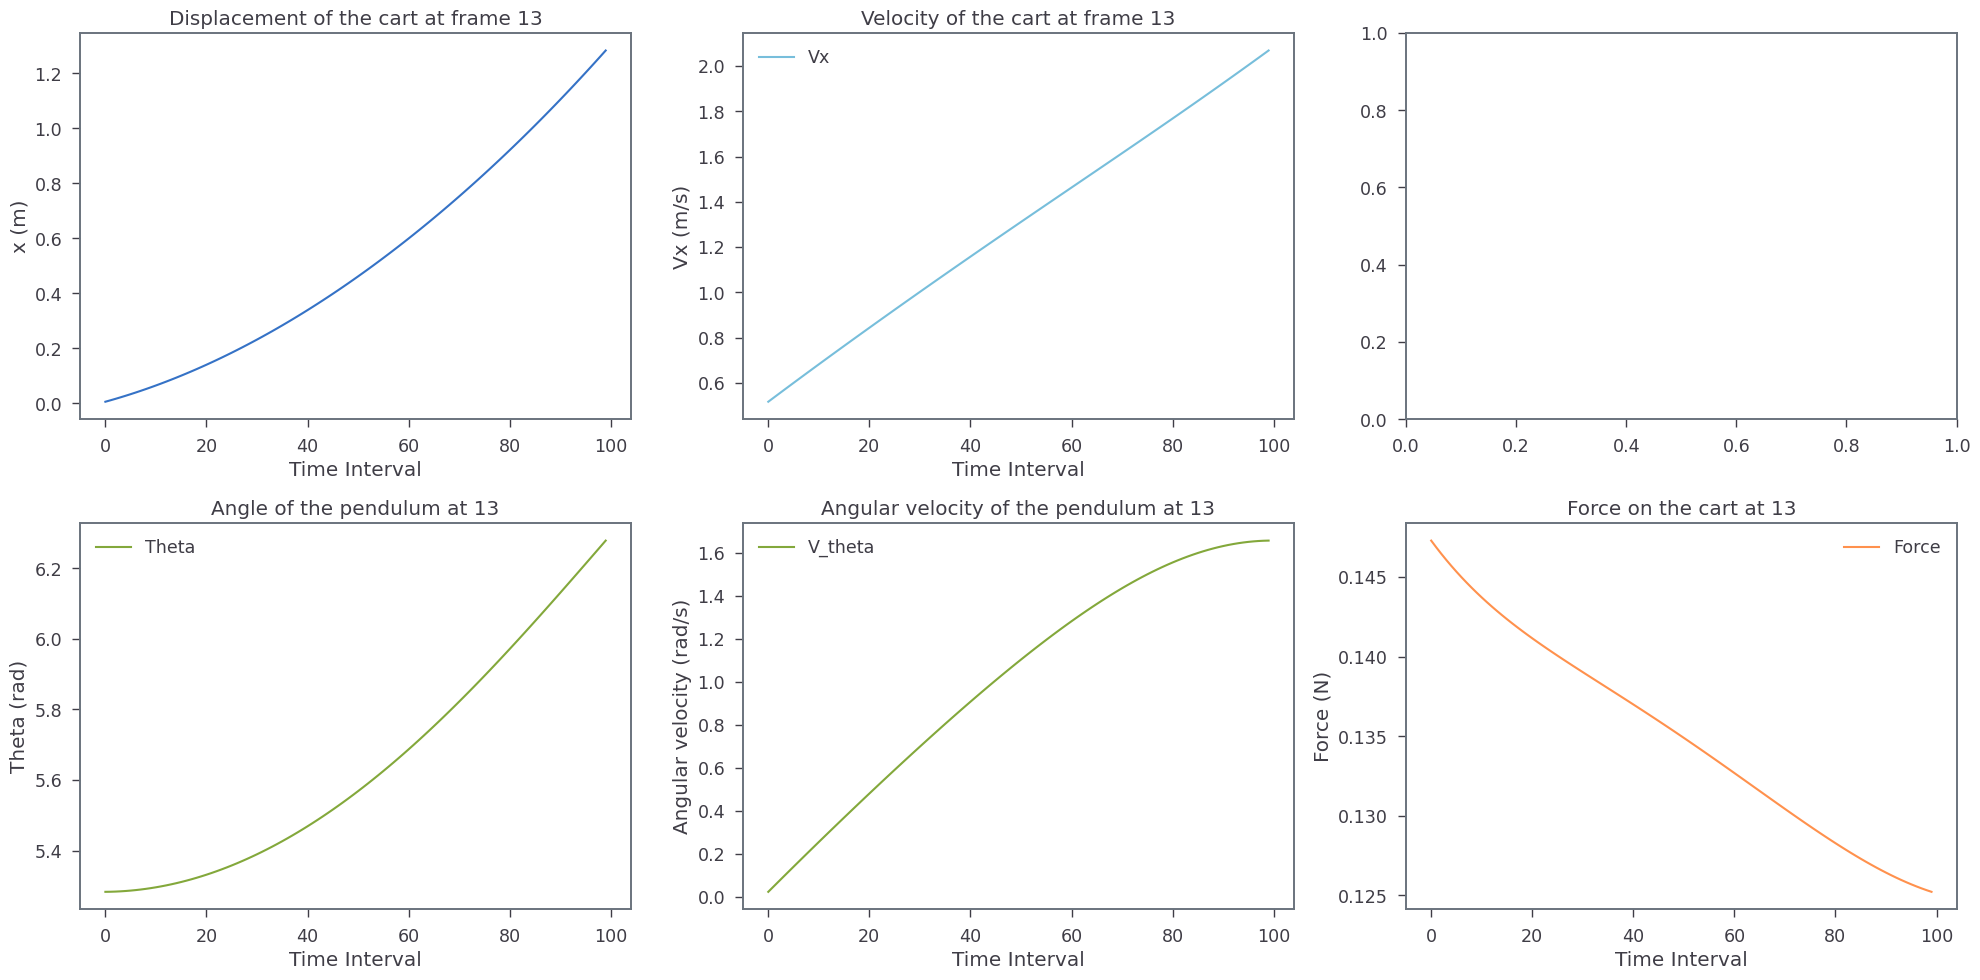

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5167724 Angular Velocity: 0.023522504 Force: 0.14728953
Angle: 302.71769963787364 5.2834206 Displacement: 0.0101677235 Velocity: 0.5334961 Angular Velocity: 0.046977766 Force: 0.14686576
Angle: 302.74463790396015 5.2838907 Displacement: 0.015502684 Velocity: 0.5501726 Angular Velocity: 0.07036674 Force: 0.14645906
Angle: 302.78493602006324 5.284594 Displacement: 0.02100441 Velocity: 0.5668035 Angular Velocity: 0.093690254 Force: 0.14606857
Angle: 302.8386213069395 5.285531 Displacement: 0.026672445 Velocity: 0.5833901 Angular Velocity: 0.11694899 Force: 0.14569335
Angle: 302.9056391230757 5.2867007 Displacement: 0.032506347 Velocity: 0.5999338 Angular Velocity: 0.14014353 Force: 0.14533255
Angle: 302.9859348269583 5.288102 Displacement: 0.038505685 Velocity: 0.61643577 Angular Velocity: 0.16327432 Force: 0.14498535
Angle: 303.07948109783086 5.289735 Displacement: 0.04467004 Velocity: 0.63289714 Angular Velocity: 0.18634

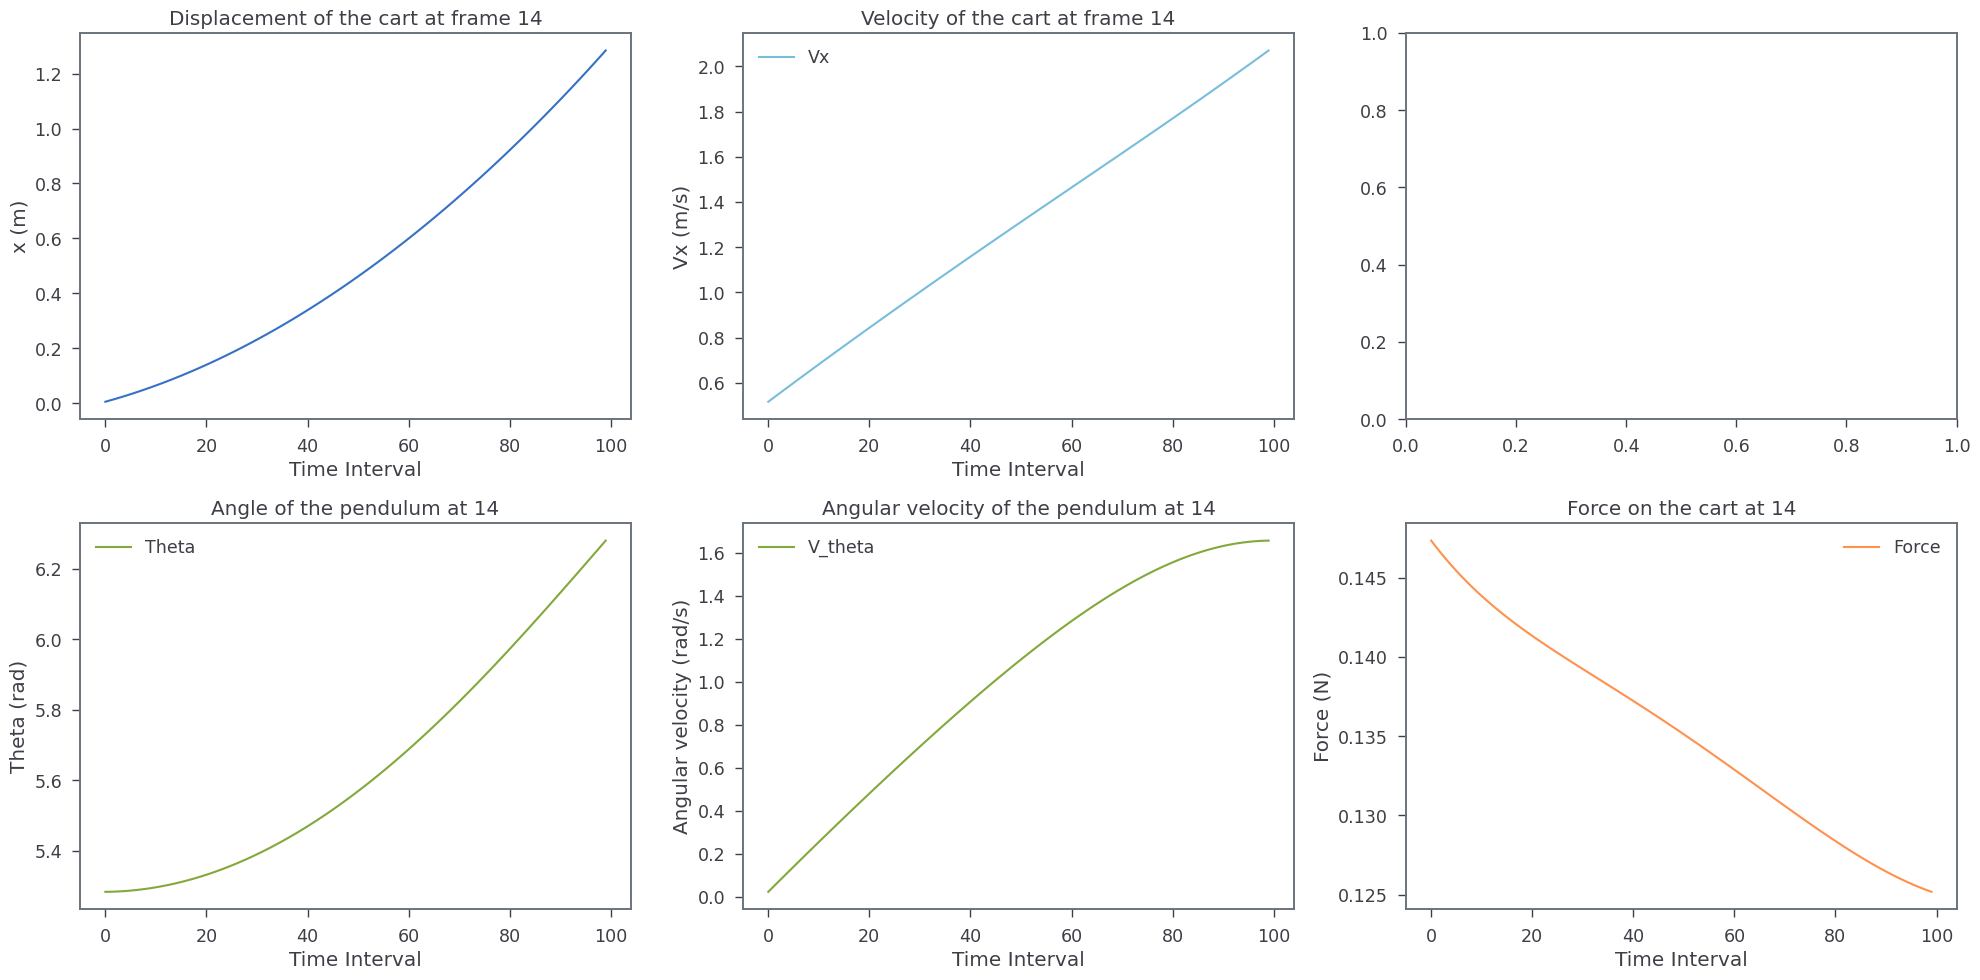

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5167771 Angular Velocity: 0.023529047 Force: 0.14733051
Angle: 302.71769963787364 5.2834206 Displacement: 0.01016777 Velocity: 0.5335064 Angular Velocity: 0.04699223 Force: 0.14691535
Angle: 302.74463790396015 5.2838907 Displacement: 0.015502834 Velocity: 0.5501895 Angular Velocity: 0.07039048 Force: 0.14651708
Angle: 302.7849633408199 5.2845945 Displacement: 0.021004729 Velocity: 0.5668279 Angular Velocity: 0.09372457 Force: 0.14613482
Angle: 302.8386759484529 5.285532 Displacement: 0.026673008 Velocity: 0.58342296 Angular Velocity: 0.11699517 Force: 0.14576761
Angle: 302.90569376458905 5.2867017 Displacement: 0.032507237 Velocity: 0.599976 Angular Velocity: 0.1402028 Force: 0.14541464
Angle: 302.9860441099851 5.288104 Displacement: 0.038506996 Velocity: 0.61648816 Angular Velocity: 0.16334789 Force: 0.14507502
Angle: 303.07961770161427 5.289737 Displacement: 0.04467188 Velocity: 0.63296056 Angular Velocity: 0.1864307 

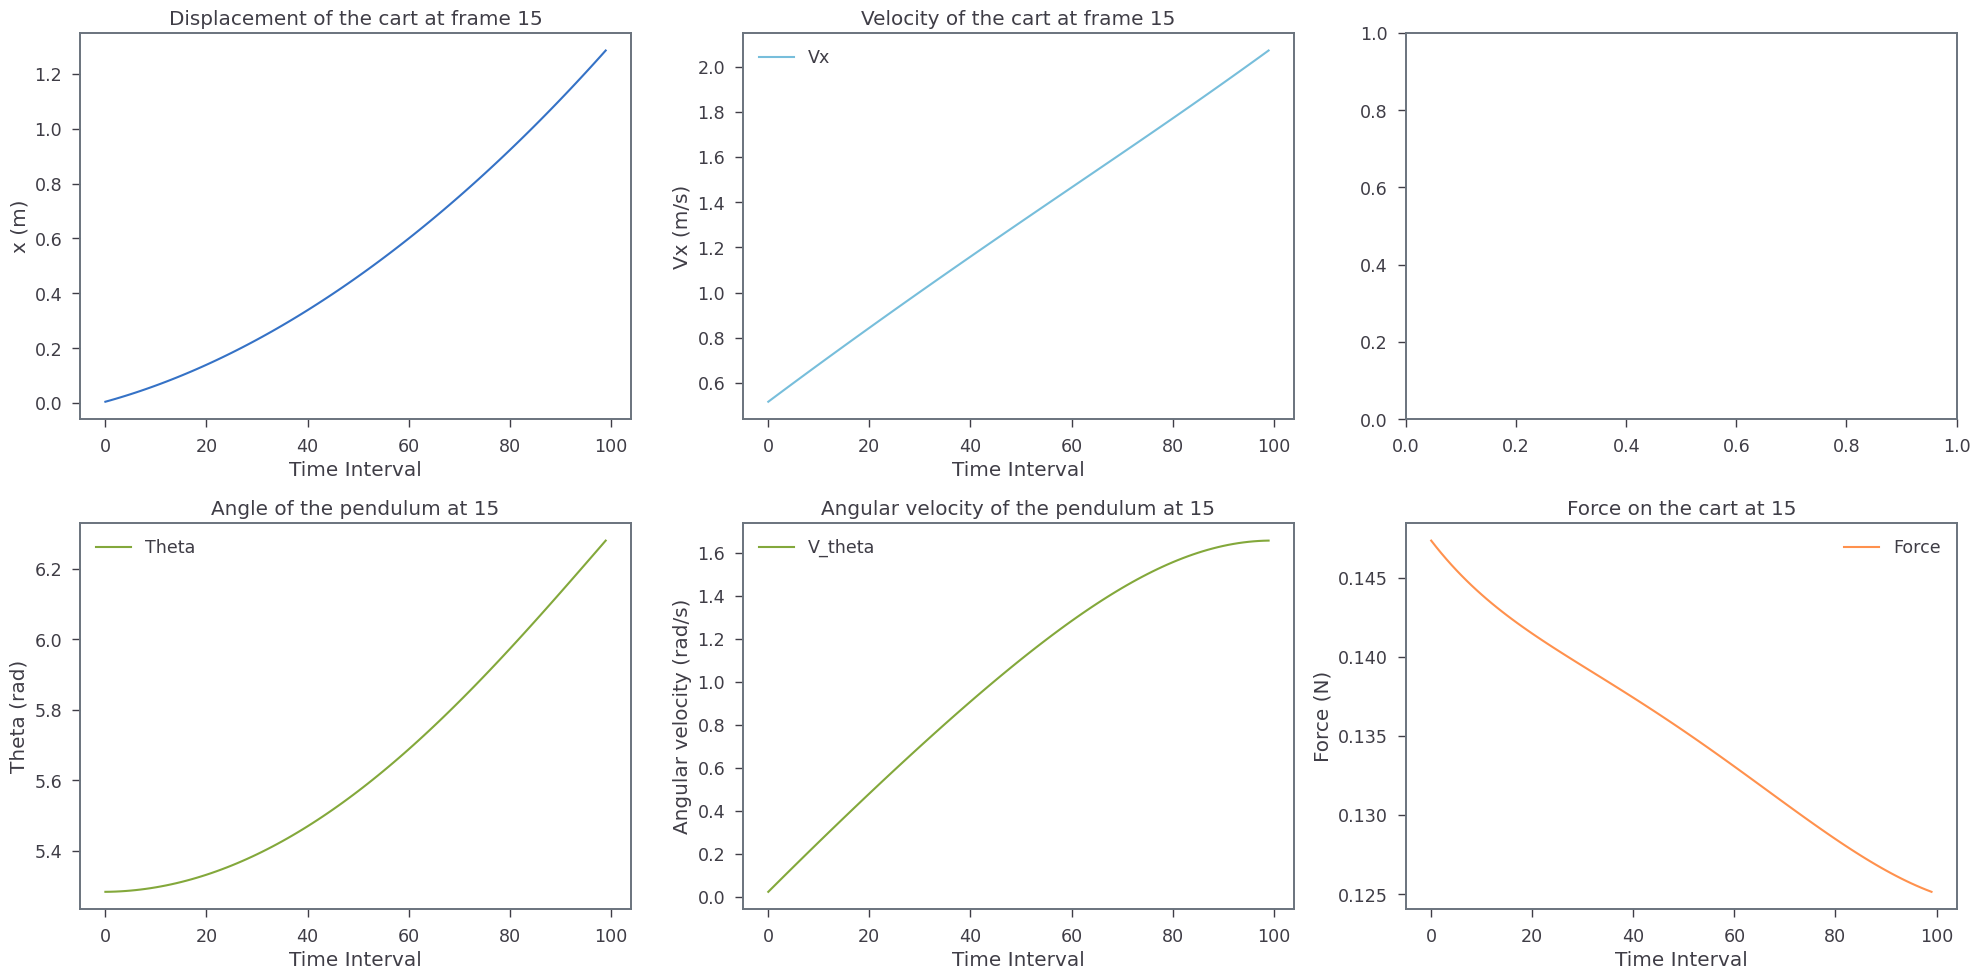

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.51677734 Angular Velocity: 0.023529384 Force: 0.14733262
Angle: 302.71769963787364 5.2834206 Displacement: 0.010167774 Velocity: 0.5335079 Angular Velocity: 0.0469943 Force: 0.14692616
Angle: 302.74463790396015 5.2838907 Displacement: 0.015502852 Velocity: 0.5501932 Angular Velocity: 0.07039563 Force: 0.14653641
Angle: 302.7849633408199 5.2845945 Displacement: 0.021004785 Velocity: 0.56683475 Angular Velocity: 0.09373413 Force: 0.1461624
Angle: 302.8386759484529 5.285532 Displacement: 0.026673133 Velocity: 0.58343387 Angular Velocity: 0.11701043 Force: 0.14580332
Angle: 302.9057210853457 5.286702 Displacement: 0.03250747 Velocity: 0.59999186 Angular Velocity: 0.14022502 Force: 0.14545819
Angle: 302.98607143074173 5.2881045 Displacement: 0.03850739 Velocity: 0.61650985 Angular Velocity: 0.16337827 Force: 0.14512624
Angle: 303.0796723431276 5.289738 Displacement: 0.04467249 Velocity: 0.6329889 Angular Velocity: 0.18647042

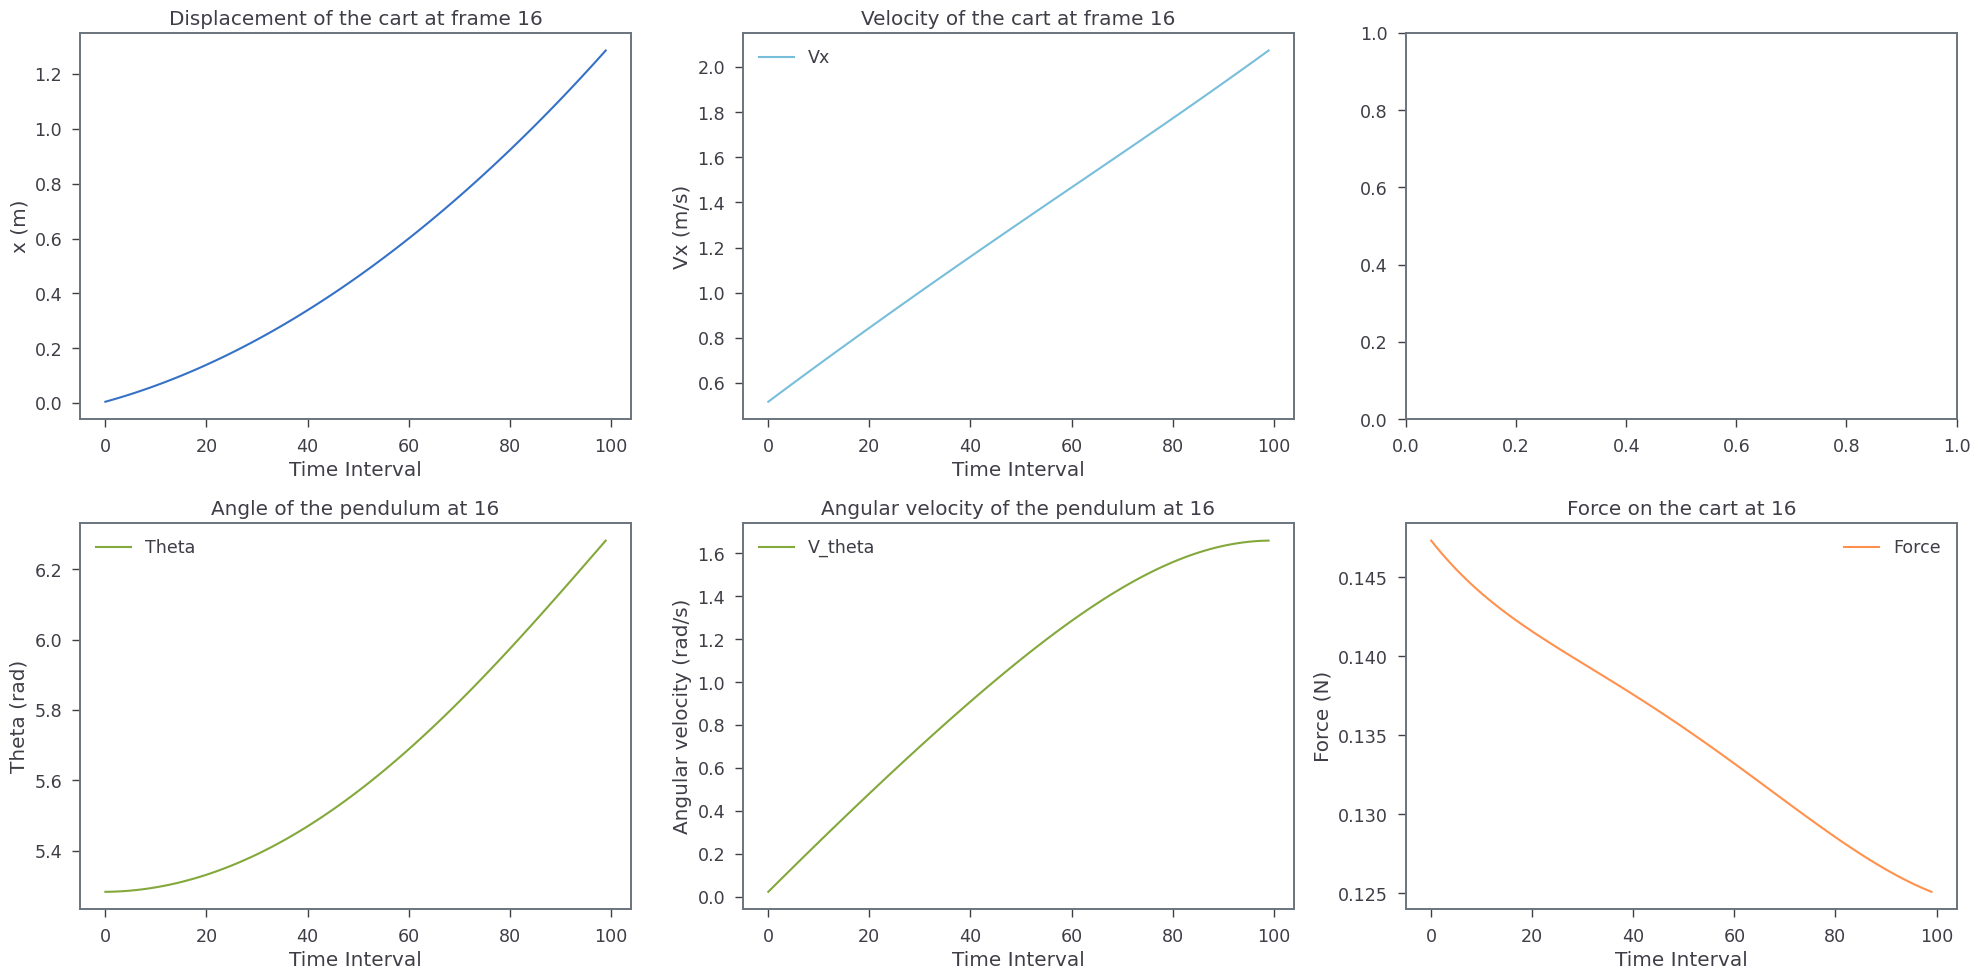

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.51677483 Angular Velocity: 0.023525897 Force: 0.1473108
Angle: 302.71769963787364 5.2834206 Displacement: 0.010167748 Velocity: 0.53350383 Angular Velocity: 0.046988655 Force: 0.14691266
Angle: 302.74463790396015 5.2838907 Displacement: 0.015502786 Velocity: 0.55018854 Angular Velocity: 0.07038912 Force: 0.14653102
Angle: 302.7849633408199 5.2845945 Displacement: 0.021004671 Velocity: 0.5668304 Angular Velocity: 0.09372801 Force: 0.14616491
Angle: 302.8386759484529 5.285532 Displacement: 0.026672974 Velocity: 0.5834307 Angular Velocity: 0.11700594 Force: 0.14581351
Angle: 302.90569376458905 5.2867017 Displacement: 0.03250728 Velocity: 0.5999907 Angular Velocity: 0.14022335 Force: 0.1454759
Angle: 302.9860441099851 5.288104 Displacement: 0.03850719 Velocity: 0.6165116 Angular Velocity: 0.1633806 Force: 0.14515127
Angle: 303.0796450223709 5.2897377 Displacement: 0.044672307 Velocity: 0.63299435 Angular Velocity: 0.1864778

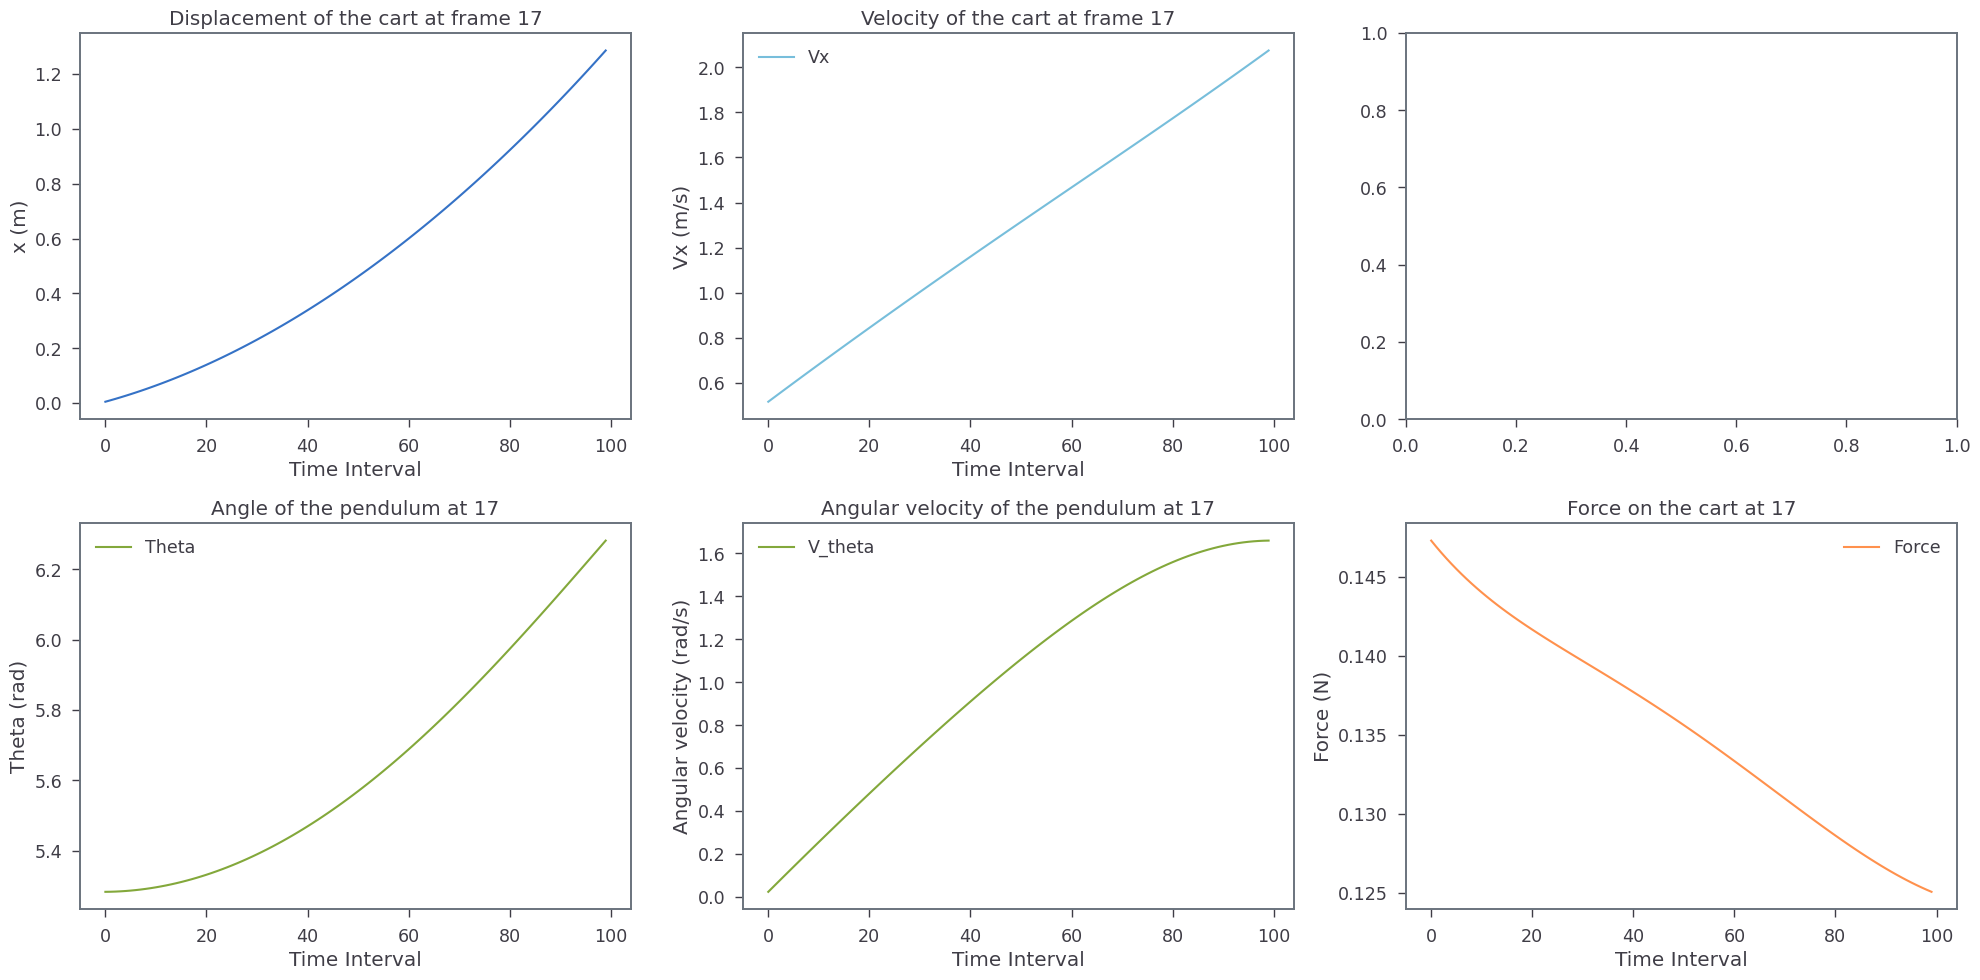

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.5167715 Angular Velocity: 0.023521192 Force: 0.14728132
Angle: 302.71769963787364 5.2834206 Displacement: 0.010167714 Velocity: 0.533498 Angular Velocity: 0.04698039 Force: 0.14689037
Angle: 302.74463790396015 5.2838907 Displacement: 0.015502694 Velocity: 0.550181 Angular Velocity: 0.070378415 Force: 0.14651571
Angle: 302.7849633408199 5.2845945 Displacement: 0.021004504 Velocity: 0.5668219 Angular Velocity: 0.09371596 Force: 0.14615645
Angle: 302.8386486276962 5.2855315 Displacement: 0.026672723 Velocity: 0.58342195 Angular Velocity: 0.11699359 Force: 0.14581168
Angle: 302.9056664438324 5.286701 Displacement: 0.032506943 Velocity: 0.5999825 Angular Velocity: 0.14021175 Force: 0.14548054
Angle: 302.9860167892284 5.2881036 Displacement: 0.03850677 Velocity: 0.6165046 Angular Velocity: 0.16337073 Force: 0.14516221
Angle: 303.07961770161427 5.289737 Displacement: 0.044671815 Velocity: 0.6329893 Angular Velocity: 0.18647073

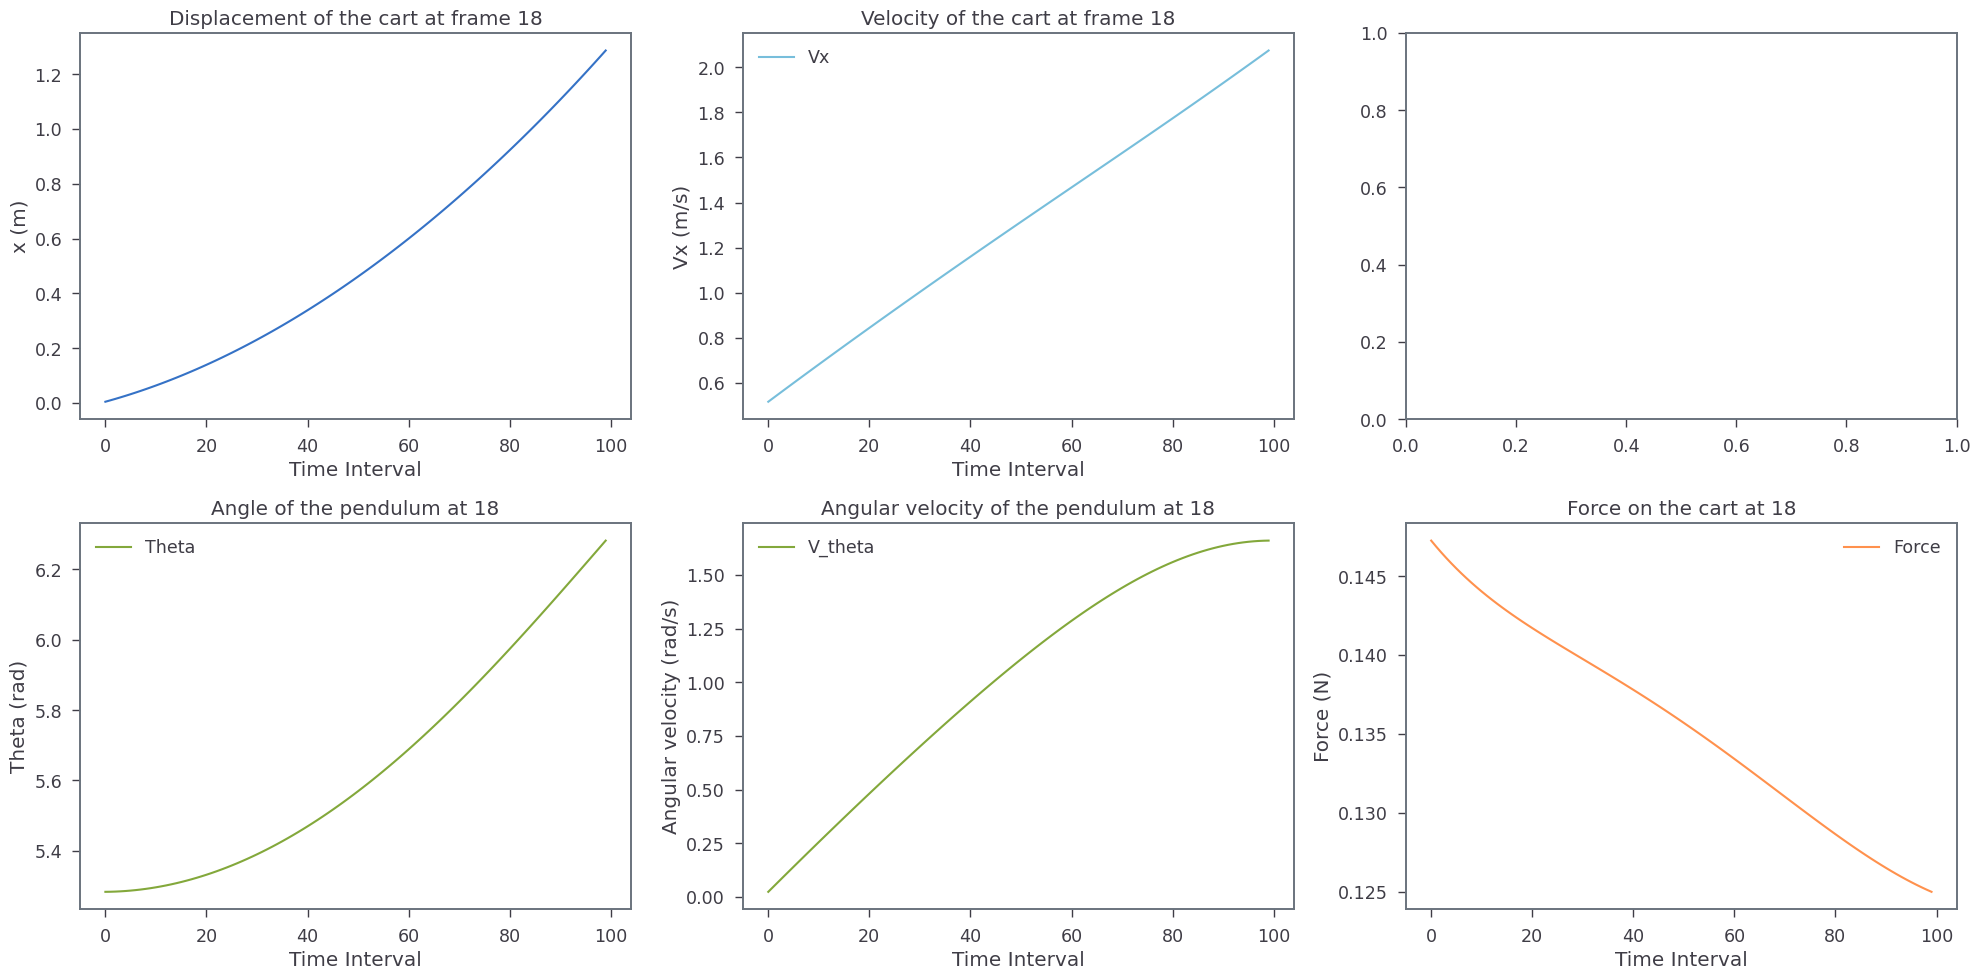

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.51676816 Angular Velocity: 0.023516564 Force: 0.14725235
Angle: 302.71769963787364 5.2834206 Displacement: 0.010167681 Velocity: 0.53349197 Angular Velocity: 0.046972066 Force: 0.14686722
Angle: 302.74461058320344 5.2838902 Displacement: 0.0155026 Velocity: 0.5501729 Angular Velocity: 0.07036731 Force: 0.14649825
Angle: 302.78493602006324 5.284594 Displacement: 0.021004329 Velocity: 0.56681246 Angular Velocity: 0.09370295 Force: 0.14614454
Angle: 302.8386213069395 5.285531 Displacement: 0.026672453 Velocity: 0.5834118 Angular Velocity: 0.11697954 Force: 0.14580517
Angle: 302.9056391230757 5.2867007 Displacement: 0.03250657 Velocity: 0.5999722 Angular Velocity: 0.1401975 Force: 0.14547929
Angle: 302.9859894684717 5.288103 Displacement: 0.03850629 Velocity: 0.6164947 Angular Velocity: 0.16335711 Force: 0.14516607
Angle: 303.0795630601009 5.2897363 Displacement: 0.044671237 Velocity: 0.6329804 Angular Velocity: 0.18645851 

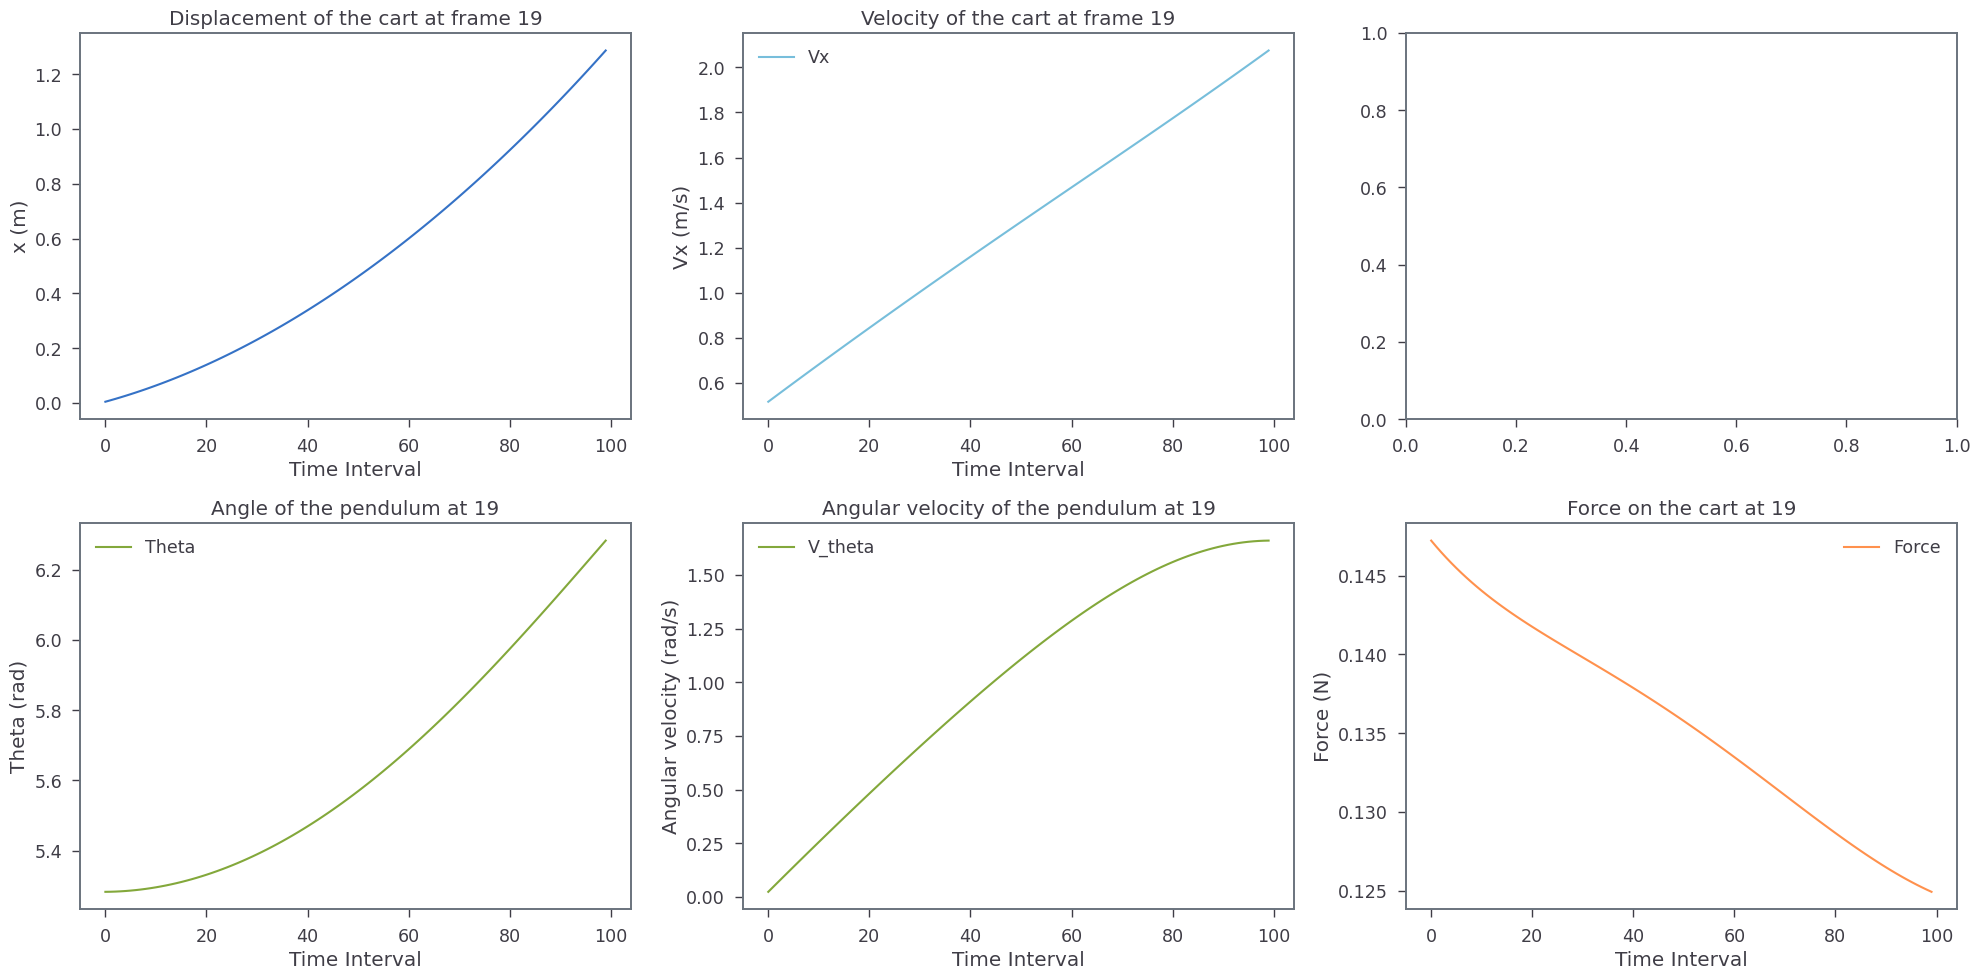

Angle: 302.7042305048303 5.2831855 Displacement: 0.005 Velocity: 0.516765 Angular Velocity: 0.023512112 Force: 0.14722447
Angle: 302.71769963787364 5.2834206 Displacement: 0.01016765 Velocity: 0.5334862 Angular Velocity: 0.046963926 Force: 0.14684415
Angle: 302.74461058320344 5.2838902 Displacement: 0.0155025115 Velocity: 0.55016506 Angular Velocity: 0.07035623 Force: 0.14647986
Angle: 302.7849086993065 5.2845936 Displacement: 0.021004163 Velocity: 0.566803 Angular Velocity: 0.093689665 Force: 0.1461307
Angle: 302.83859398618284 5.2855306 Displacement: 0.026672192 Velocity: 0.58340126 Angular Velocity: 0.11696476 Force: 0.14579576
Angle: 302.905611802319 5.2867002 Displacement: 0.032506205 Velocity: 0.5999611 Angular Velocity: 0.1401819 Force: 0.14547421
Angle: 302.9859348269583 5.288102 Displacement: 0.038505815 Velocity: 0.61648357 Angular Velocity: 0.16334137 Force: 0.1451652
Angle: 303.0795357393442 5.289736 Displacement: 0.04467065 Velocity: 0.6329696 Angular Velocity: 0.1864433 F

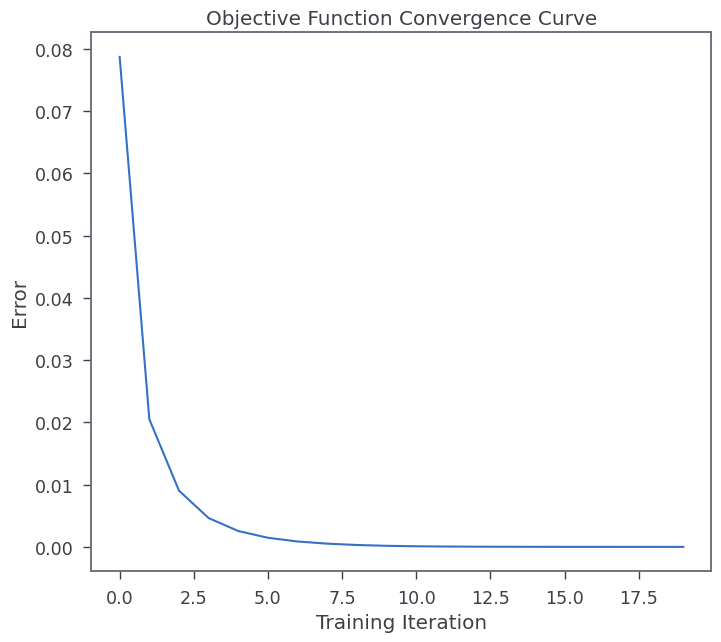

Generating Animation


IntProgress(value=0, max=101)

(100, 4) (100, 1)
/tmp/ipykernel_36/1393961.py:142: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pend_fig.set_data(pendulum_x, pendulum_y)
/tmp/ipykernel_36/1393961.py:143: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cart_fig.set_data(cart_x,0)
/tmp/ipykernel_36/1393961.py:146: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  force_fig.set_data(cart_x+force_1 -0.5,0)


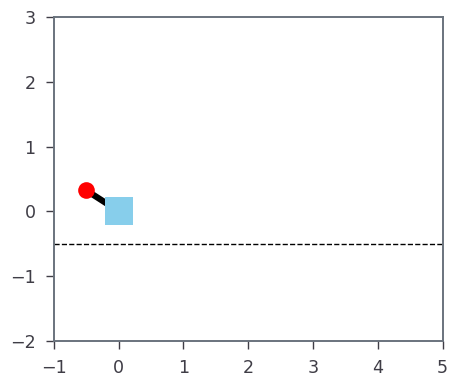

In [17]:
T = 100  # number of time steps of the simulation
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(20)  # training with number of epochs (gradient descent steps)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e7c2bc5a-8560-49b0-9204-5d9e2bfeb73a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>